In [1]:
import simpy
import uuid
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


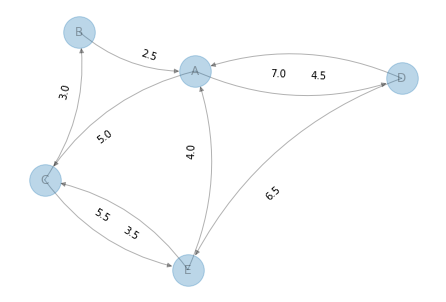

In [2]:
df = pd.DataFrame({'s': ['D', 'A', 'B', 'C', 'A', 'D', 'C', 'E', 'E'],
                   't': ['A', 'D', 'A', 'E', 'C', 'E', 'B', 'A', 'C'],
                   'w': [7., 4.5, 2.5, 3.5, 5., 6.5, 3., 4., 5.5]})
G = nx.from_pandas_edgelist(df, 's', 't', edge_attr=True, create_using=nx.DiGraph())
pos = nx.kamada_kawai_layout(G, weight='w')
labels = nx.get_edge_attributes(G, 'w')
nx.draw(G, pos, with_labels=True, node_size=1000, alpha=0.3, arrows=True, connectionstyle='arc3,rad=0.2')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, label_pos=0.4)
plt.show()

In [3]:
class AppSite(object):
    """
    Application site, i.e. tool, in the FAB.
    This corresponds to a node in the graph.
    We model an application site using the simpy.Resource data type.
    We impose FOUP capacity constraints on the buffer and the application.
    Constraint: app_capacity <= buffer_capacity
    """
    def __init__(self, env, node, app_capacity, buffer_capacity, processing_time, buffering_time):
        self.node = node
        self.app = simpy.Resource(env, capacity=app_capacity)
        self.buffer = simpy.Resource(env, capacity=buffer_capacity)
        self.processing_time = processing_time
        self.buffering_time = buffering_time

In [4]:
class RailPath(object):
    """
    Path in the FAB's overhead rail system.
    This corresponds to an edge in the graph.
    We model a rail path using the simpy.Store data type.
    We use shared resource objects to model rail path traffic flow.
    """
    def __init__(self, env, edge, weight, traffic_function):
        self.edge = edge
        self.ohts = simpy.Store(env)
        self.weight = weight
        self.traffic_function = traffic_function
    
    def transfer_time(self):
        return self.weight + self.traffic_function(len(self.ohts.items))

In [5]:
class FOUP(object):
    """
    Front-opening unified pod containing semiconductor wafers.
    The goal of the FAB is to process wafers as efficiently as possible.
    Our FOUP representation uses an ordered list of application demands.
    """
    def __init__(self, env, create_time, demands, uuid):
        self.env = env
        self.create_time = create_time
        self.demands = demands
        self.location = demands[0]
        self.uuid = uuid
        # WAIT IN, TRANSFERRING, COMPLETED, APPLICATION, WAIT OUT
        self.status = 'WAIT IN'

    def at_destination(self):
        return len(self.demands) > 0 and self.demands[0] == self.location

    def can_use(self, app_site):
        return ((self.status == 'WAIT IN' or self.status == 'COMPLETED') and
                self.at_destination() and self.location == app_site.node)

    def use(self, app_site):
        if self.can_use(app_site):
            if self.status == 'WAIT IN':
                # create FOUP
                yield self.env.timeout(self.create_time)
                self.buf_request = app_site.buffer.request()
                yield self.buf_request
            self.status = 'APPLICATION'
            with app_site.app.request() as req:
                yield req
                print('FOUP %s using AppSite %s at time %3.1f' %
                      (self.uuid, app_site.node, self.env.now))
                yield self.env.timeout(app_site.processing_time)
                # complete the leading demand
                self.demands = self.demands[1:]
                self.status = 'COMPLETED' if len(self.demands) > 0 else 'WAIT OUT'
            # this technically belongs in acquire, but the "training wheels"
            # of using it here make deadlock impossible
            app_site.buffer.release(self.buf_request)

In [6]:
class OHT(object):
    """
    Overhead hoist transfer in the FAB.
    OHTs carry FOUPs from one application site to another via rail paths in the FAB.
    """
    def __init__(self, env, location, uuid):
        self.env = env
        self.location = location
        self.uuid = uuid
        # PARKED, ENROUTE, ACQUIRING, DEPOSITING, REMOVED
        self.status = 'PARKED'
        self.foup = None

    def can_take(self, rail_path):
        return self.status == 'PARKED' and self.location == rail_path.edge[0]

    def take(self, rail_path):
        if self.can_take(rail_path):
            self.status = 'ENROUTE'
            print('OHT %s taking RailPath %s at time %3.1f' %
                  (self.uuid, rail_path.edge, self.env.now))
            # compute transfer time before adding ourselves to the simpy.Store
            transfer_time = rail_path.transfer_time()
            rail_path.ohts.put(self)
            yield self.env.timeout(transfer_time)
            rail_path.ohts.get()
            # bring FOUP along with us
            if (self.foup is not None and
                    self.foup.status == 'TRANSFERRING' and
                    self.foup.location == self.location):
                self.foup.location = rail_path.edge[1]
            self.status = 'PARKED'
            self.location = rail_path.edge[1]

    def can_acquire(self, app_site, foup):
        return (self.foup is None and
                self.status == 'PARKED' and foup.status == 'COMPLETED' and
                self.location == foup.location == app_sscenario(VehicleAMHS, foup_count)ite.node)

    def acquire(self, app_site, foup):
        if self.can_acquire(app_site, foup):
            self.status = 'ACQUIRING'
            print('OHT %s acquiring FOUP %s at AppSite %s at time %3.1f' %
                  (self.uuid, foup.uuid, app_site.node, self.env.now))
            yield self.env.timeout(app_site.buffering_time)
            self.foup = foup
            self.foup.status = 'TRANSFERRING'
            self.status = 'PARKED'
            # app_site.buffer.release(self.foup.buf_request)

    def can_deposit(self, app_site):
        return (self.foup is not None and
                self.status == 'PARKED' and self.foup.status == 'TRANSFERRING' and
                self.location == self.foup.location == app_site.node)

    def deposit(self, app_site):
        if self.can_deposit(app_site):
            self.status = 'DEPOSITING'
            self.foup.buf_request = app_site.buffer.request()
            yield self.foup.buf_request
            print('OHT %s depositing FOUP %s at AppSite %s at time %3.1f' %
                  (self.uuid, self.foup.uuid, app_site.node, self.env.now))
            yield self.env.timeout(app_site.buffering_time)
            # unpair our FOUP
            self.status = 'PARKED'
            self.foup.status = 'COMPLETED'
            self.foup = None

In [7]:
class MHS(object):
    """
    Material handling system in the FAB.
    Includes AppSites, RailPaths, FOUPs, OHTs, and the graph G.
    """
    def __init__(self, app_sites, rail_paths, foups, ohts, G):
        self.app_sites = app_sites
        self.rail_paths = rail_paths
        self.foups = foups
        self.ohts = ohts
        self.G = G

In [8]:
class AMHS():
    """
    Automated material handling system.
    Defines the logic of our FAB.
    """
    def __init__(self, env, mhs):
        self.env = env
        self.mhs = mhs
        self.action = env.process(self.run())

    def run(self):
        # AMHS LOGIC HERE
        pass

In [9]:
class GreedyAMHS(AMHS):
    """
    Greedily pairs OHTs to FOUPs.
    """
    def run(self):
        sp = dict(nx.all_pairs_dijkstra_path(self.mhs.G, weight='w'))
        req = self.mhs.foups.get()
        foup = yield req
        while True:
            app = self.mhs.app_sites[foup.location]
            if foup.at_destination():
                # case 1: our FOUP has reached its next checkpoint
                assert foup.can_use(app)
                yield self.env.process(foup.use(app))
            elif foup.status == 'COMPLETED':
                # case 2: our FOUP is waiting for an OHT
                req = self.mhs.ohts.get()
                oht = yield req
                # move OHT to FOUP
                while oht.location != foup.location:
                    e = tuple(sp[oht.location][foup.location][:2])
                    p = self.mhs.rail_paths[e]
                    assert oht.can_take(p)
                    yield self.env.process(oht.take(p))
                # acquire FOUP
                assert oht.can_acquire(app, foup)
                yield self.env.process(oht.acquire(app, foup))
                # move OHT to destination
                while not foup.at_destination():
                    e = tuple(sp[oht.location][foup.demands[0]][:2])
                    p = self.mhs.rail_paths[e]
                    assert oht.can_take(p)
                    yield self.env.process(oht.take(p))
                app = self.mhs.app_sites[foup.demands[0]]
                # deposit FOUP
                assert oht.can_deposit(app)
                yield self.env.process(oht.deposit(app))
                self.mhs.ohts.put(oht)
            elif foup.status == 'WAIT OUT':
                break
            else:
                assert False

In [10]:
env = simpy.Environment()
app_sites = {
    'A': AppSite(env, 'A', 1,  10, 3.,  0.5),
    'B': AppSite(env, 'B', 10, 10, 10., 0.5),
    'C': AppSite(env, 'C', 5,  5,  5.,  0.5),
    'D': AppSite(env, 'D', 50, 50, 1.,  0.5),
    'E': AppSite(env, 'E', 50, 50, 1.,  0.5)
}
rail_paths = {}
for e in G.edges:
    weight = G[e[0]][e[1]]['w']
    # ReLU function for traffic flow
    traffic_function = lambda x : 0 if x < weight else x - weight
    rail_paths[e] = RailPath(env, e, weight, traffic_function)
foups = simpy.Store(env)
foups.put(FOUP(env, 0., ['D', 'B', 'E'], str(uuid.uuid4())[:8]))
ohts = simpy.Store(env)
ohts.put(OHT(env, 'E', str(uuid.uuid4())[:8]))
mhs = MHS(app_sites, rail_paths, foups, ohts, G)
GreedyAMHS(env, mhs)
env.run()

FOUP b89d38a7 using AppSite D at time 0.0
OHT 8325012c taking RailPath ('E', 'A') at time 1.0
OHT 8325012c taking RailPath ('A', 'D') at time 5.0
OHT 8325012c acquiring FOUP b89d38a7 at AppSite D at time 9.5
OHT 8325012c taking RailPath ('D', 'E') at time 10.0
OHT 8325012c taking RailPath ('E', 'C') at time 16.5
OHT 8325012c taking RailPath ('C', 'B') at time 22.0
OHT 8325012c depositing FOUP b89d38a7 at AppSite B at time 25.0
FOUP b89d38a7 using AppSite B at time 25.5
OHT 8325012c acquiring FOUP b89d38a7 at AppSite B at time 35.5
OHT 8325012c taking RailPath ('B', 'A') at time 36.0
OHT 8325012c taking RailPath ('A', 'C') at time 38.5
OHT 8325012c taking RailPath ('C', 'E') at time 43.5
OHT 8325012c depositing FOUP b89d38a7 at AppSite E at time 47.0
FOUP b89d38a7 using AppSite E at time 47.5


In [11]:
env = simpy.Environment()
app_sites = {
    'A': AppSite(env, 'A', 1,  10, 3.,  0.5),
    'B': AppSite(env, 'B', 10, 10, 10., 0.5),
    'C': AppSite(env, 'C', 5,  5,  5.,  0.5),
    'D': AppSite(env, 'D', 50, 50, 1.,  0.5),
    'E': AppSite(env, 'E', 50, 50, 1.,  0.5)
}
rail_paths = {}
for e in G.edges:
    weight = G[e[0]][e[1]]['w']
    # ReLU function for traffic flow
    traffic_function = lambda x : 0 if x < weight else x - weight
    rail_paths[e] = RailPath(env, e, weight, traffic_function)
foups = simpy.Store(env)
foups.put(FOUP(env, 0., ['D', 'B', 'E'], str(uuid.uuid4())[:8]))
foups.put(FOUP(env, 20., ['D', 'A', 'C', 'E'], str(uuid.uuid4())[:8]))
ohts = simpy.Store(env)
ohts.put(OHT(env, 'E', str(uuid.uuid4())[:8]))
mhs = MHS(app_sites, rail_paths, foups, ohts, G)
GreedyAMHS(env, mhs)
GreedyAMHS(env, mhs)
env.run()

FOUP b106ed4d using AppSite D at time 0.0
OHT 72a63873 taking RailPath ('E', 'A') at time 1.0
OHT 72a63873 taking RailPath ('A', 'D') at time 5.0
OHT 72a63873 acquiring FOUP b106ed4d at AppSite D at time 9.5
OHT 72a63873 taking RailPath ('D', 'E') at time 10.0
OHT 72a63873 taking RailPath ('E', 'C') at time 16.5
FOUP c17c1d81 using AppSite D at time 20.0
OHT 72a63873 taking RailPath ('C', 'B') at time 22.0
OHT 72a63873 depositing FOUP b106ed4d at AppSite B at time 25.0
FOUP b106ed4d using AppSite B at time 25.5
OHT 72a63873 taking RailPath ('B', 'A') at time 25.5
OHT 72a63873 taking RailPath ('A', 'D') at time 28.0
OHT 72a63873 acquiring FOUP c17c1d81 at AppSite D at time 32.5
OHT 72a63873 taking RailPath ('D', 'A') at time 33.0
OHT 72a63873 depositing FOUP c17c1d81 at AppSite A at time 40.0
FOUP c17c1d81 using AppSite A at time 40.5
OHT 72a63873 taking RailPath ('A', 'C') at time 40.5
OHT 72a63873 taking RailPath ('C', 'B') at time 45.5
OHT 72a63873 acquiring FOUP b106ed4d at AppSite 

In [12]:
N = 1000
λ = 0.5
foup_spawn = np.random.random(size=(N,2)) < λ
foup_count = foup_spawn.sum()
oht_count = 50

In [13]:
def scenario(MyAMHS, controllers):
    env = simpy.Environment()
    app_sites = {
        'A': AppSite(env, 'A', 1,  10, 3.,  0.5),
        'B': AppSite(env, 'B', 10, 10, 10., 0.5),
        'C': AppSite(env, 'C', 5,  5,  5.,  0.5),
        'D': AppSite(env, 'D', 50, 50, 1.,  0.5),
        'E': AppSite(env, 'E', 50, 50, 1.,  0.5)
    }
    rail_paths = {}
    for e in G.edges:
        weight = G[e[0]][e[1]]['w']
        # ReLU function for traffic flow
        traffic_function = lambda x : 0 if x < weight else x - weight
        rail_paths[e] = RailPath(env, e, weight, traffic_function)
    foups = simpy.FilterStore(env)
    for i in range(N):
        if foup_spawn[i][0]:
            foups.put(FOUP(env, i, ['D', 'B', 'E'], str(uuid.uuid4())))
        if foup_spawn[i][1]:
            foups.put(FOUP(env, i, ['D', 'A', 'C', 'E'], str(uuid.uuid4())))
    ohts = simpy.FilterStore(env)
    for _ in range(oht_count):
        ohts.put(OHT(env, 'D', str(uuid.uuid4())))
    mhs = MHS(app_sites, rail_paths, foups, ohts, G)
    for _ in range(controllers):
        MyAMHS(env, mhs)
    env.run()

In [14]:
scenario(GreedyAMHS, foup_count)

FOUP b21ef1c1-40e6-4c70-af38-4e9292a8c0a2 using AppSite D at time 0.0
FOUP feedd521-6722-4a91-8616-fe4debf165e8 using AppSite D at time 1.0
OHT f3ed9742-7d79-4bd3-8c82-3c61115b87b2 acquiring FOUP b21ef1c1-40e6-4c70-af38-4e9292a8c0a2 at AppSite D at time 1.0
OHT f3ed9742-7d79-4bd3-8c82-3c61115b87b2 taking RailPath ('D', 'E') at time 1.5
OHT 2e9ea960-e96c-4e95-b604-ec2ef57c4134 acquiring FOUP feedd521-6722-4a91-8616-fe4debf165e8 at AppSite D at time 2.0
OHT 2e9ea960-e96c-4e95-b604-ec2ef57c4134 taking RailPath ('D', 'E') at time 2.5
FOUP 3e2a6398-a313-4249-91ec-540e5e07be7e using AppSite D at time 3.0
FOUP dbc755b9-7db6-4026-9154-baf2708382df using AppSite D at time 4.0
OHT c10cd996-cb2e-4186-b834-2117140b66bd acquiring FOUP 3e2a6398-a313-4249-91ec-540e5e07be7e at AppSite D at time 4.0
OHT c10cd996-cb2e-4186-b834-2117140b66bd taking RailPath ('D', 'E') at time 4.5
FOUP 7c82f7d9-b135-4733-9b26-c593cbc942ba using AppSite D at time 5.0
FOUP aa0f28ce-f4b8-44a9-bb8f-7921c855a834 using AppSite 

FOUP 6881b53a-db0b-4266-82ac-febbc5d0e144 using AppSite D at time 129.0
OHT 464c581d-aae4-4f3c-a448-5d851f021613 taking RailPath ('C', 'B') at time 129.0
OHT 1c95106f-79f7-4c59-b98d-c92b1d70d762 depositing FOUP 7082d13c-32c2-4fec-8764-c4ea59cc25f1 at AppSite C at time 129.0
OHT a25925ae-8a77-49a0-91dc-4a3060e445e8 depositing FOUP 29c3636d-793e-41e8-aec3-5d9ed7579362 at AppSite B at time 129.0
OHT d506b794-a70e-4945-b94d-26be01f111a3 taking RailPath ('B', 'A') at time 129.0
FOUP 1fe98592-ab44-4384-81ec-325f3ea50d02 using AppSite E at time 129.0
FOUP e8fb7821-e85f-4046-b19f-a3885eebf682 using AppSite B at time 129.0
OHT 8a413b95-bb53-425d-9517-ffcfad60d657 acquiring FOUP e3af1d39-785d-43c3-afda-e7bf3b3df0db at AppSite C at time 129.5
OHT 5d98e079-3990-45b6-87af-f31e1a3e6798 acquiring FOUP 698cc352-3f4f-43e6-b219-2885d30d71e4 at AppSite D at time 129.5
OHT 2b275a57-e0bd-4ceb-a535-1dead6fcd4e3 acquiring FOUP 1291a155-5e1f-49c2-a544-6ccb65627da4 at AppSite B at time 129.5
OHT a1f8cb8b-1d12-

OHT 2c115796-c0a2-44b3-b59b-a6635911bb61 acquiring FOUP 32c85ec2-9d6f-4c70-adca-7aeb4aec6086 at AppSite D at time 151.5
OHT 66e72440-4f90-4e59-a591-17b324ff57fe acquiring FOUP f838ca0b-0967-423e-af66-59b0add274b9 at AppSite D at time 151.5
OHT 5e8975e8-2653-4b75-8884-acaf6c5b0584 taking RailPath ('A', 'D') at time 151.5
OHT a25925ae-8a77-49a0-91dc-4a3060e445e8 taking RailPath ('C', 'E') at time 151.5
OHT 2836f6cc-4f43-4580-b3bf-6a8bf5ae8ed8 taking RailPath ('C', 'E') at time 151.5
OHT d4726827-88f3-4886-a837-bf0d56116ef7 taking RailPath ('C', 'E') at time 151.5
OHT d506b794-a70e-4945-b94d-26be01f111a3 depositing FOUP 246f8264-32d4-4e53-8656-46e5f1043406 at AppSite B at time 151.5
OHT 7a267bc3-806d-4bb4-96e5-c9093024d63a taking RailPath ('A', 'D') at time 151.5
OHT 464c581d-aae4-4f3c-a448-5d851f021613 taking RailPath ('C', 'B') at time 152.0
OHT 115036d2-0a1b-4ec9-883a-412ab81599cc taking RailPath ('A', 'C') at time 152.0
OHT 2c115796-c0a2-44b3-b59b-a6635911bb61 taking RailPath ('D', 'A

OHT 2836f6cc-4f43-4580-b3bf-6a8bf5ae8ed8 taking RailPath ('A', 'D') at time 241.0
OHT 135165ed-1cae-43a3-b7d4-7a936f77b1ad taking RailPath ('A', 'D') at time 241.0
FOUP a1ffb805-a8e8-4472-bd12-a64f5e81b835 using AppSite D at time 241.0
OHT f3ed9742-7d79-4bd3-8c82-3c61115b87b2 depositing FOUP 8ee3e468-53ab-40ce-b4d5-72853f79bdce at AppSite B at time 241.0
FOUP 32c85ec2-9d6f-4c70-adca-7aeb4aec6086 using AppSite A at time 241.0
OHT a25925ae-8a77-49a0-91dc-4a3060e445e8 depositing FOUP 34fe3fe3-063c-4137-956e-f7bf381c2391 at AppSite A at time 241.0
FOUP be2ef8b2-8792-4776-a55d-15b18dd3f2e8 using AppSite B at time 241.0
OHT 7a267bc3-806d-4bb4-96e5-c9093024d63a taking RailPath ('B', 'A') at time 241.0
OHT 012643cf-9e42-4cee-a4e5-f30f3c60edc5 taking RailPath ('C', 'B') at time 241.5
OHT 2b275a57-e0bd-4ceb-a535-1dead6fcd4e3 taking RailPath ('C', 'B') at time 241.5
OHT 746d2f30-2fdf-4d73-bab2-ebfb2ec252e0 acquiring FOUP d19a2d1f-945c-425a-9828-3007b4e7b798 at AppSite D at time 241.5
OHT 9666666b

OHT 012643cf-9e42-4cee-a4e5-f30f3c60edc5 taking RailPath ('A', 'C') at time 270.5
OHT 7275f979-f442-4f9d-a694-03b46d76f27e acquiring FOUP 0b3f4e11-133b-40c4-998e-1f45c6d75f0d at AppSite A at time 270.5
OHT d0bae13b-7552-4017-9974-54c4ebc63ce3 taking RailPath ('D', 'A') at time 270.5
OHT 4981a940-7280-42aa-884b-7a38d516f1c1 taking RailPath ('C', 'B') at time 271.0
OHT a6d83327-7754-4503-ae6a-fa705d26cc82 taking RailPath ('A', 'D') at time 271.0
OHT 7275f979-f442-4f9d-a694-03b46d76f27e taking RailPath ('A', 'C') at time 271.0
FOUP 3bd95807-d516-4b65-9967-a9cc96a4c19c using AppSite D at time 271.0
FOUP 00a73528-9294-409c-ac0c-ec5698573488 using AppSite A at time 271.0
OHT 5d98e079-3990-45b6-87af-f31e1a3e6798 depositing FOUP bfe55a61-4a36-4767-81e9-a827466fc3e9 at AppSite A at time 271.0
OHT e861bb63-7a28-46e5-9724-b3e7a6ea0963 taking RailPath ('A', 'D') at time 271.5
OHT dc3b9603-7a08-41ce-bb6e-bf43746cfc31 taking RailPath ('B', 'A') at time 271.5
OHT 5d98e079-3990-45b6-87af-f31e1a3e6798 

OHT 4cbe5b0b-590f-4f13-a3b8-42fcd915f432 depositing FOUP 90f6215e-8b67-4094-b9ef-74d7b58dfcd4 at AppSite E at time 370.5
FOUP bfe55a61-4a36-4767-81e9-a827466fc3e9 using AppSite C at time 370.5
FOUP d1dab036-4428-44c6-be6b-da0cb4ab86b5 using AppSite B at time 370.5
OHT 8e915821-574a-452e-bfcb-a402ed7b8841 acquiring FOUP 7f6b5624-3d28-4397-a2ac-b745cf4711c5 at AppSite A at time 370.5
OHT a6d83327-7754-4503-ae6a-fa705d26cc82 taking RailPath ('C', 'B') at time 370.5
OHT 464c581d-aae4-4f3c-a448-5d851f021613 acquiring FOUP 2f6a8b00-27d6-4c0d-8b7f-9788235f3c54 at AppSite B at time 370.5
OHT ac940608-d9d3-4f59-b580-8417b78bf0d4 taking RailPath ('C', 'E') at time 371.0
OHT 13cd45ad-e1fc-4bdb-be46-f42351be4ddb taking RailPath ('A', 'D') at time 371.0
OHT f378a8dc-9ffe-4a9b-bb99-91ee4c0a0e35 taking RailPath ('D', 'A') at time 371.0
OHT 8e915821-574a-452e-bfcb-a402ed7b8841 taking RailPath ('A', 'C') at time 371.0
OHT 464c581d-aae4-4f3c-a448-5d851f021613 taking RailPath ('B', 'A') at time 371.0
FOU

OHT 98e8fd6b-3d66-48b0-a5b5-3a4362fcd7c6 acquiring FOUP bbb6240b-2e5b-46ea-8d58-7df27245c7a6 at AppSite A at time 385.0
OHT d506b794-a70e-4945-b94d-26be01f111a3 taking RailPath ('C', 'E') at time 385.0
OHT a25925ae-8a77-49a0-91dc-4a3060e445e8 taking RailPath ('B', 'A') at time 385.0
OHT 096ff8d0-ab4b-4958-aaba-88c38ee56ebf depositing FOUP fb99c559-4bea-4fd3-b911-0dcf198c1a40 at AppSite A at time 385.0
OHT a6d83327-7754-4503-ae6a-fa705d26cc82 depositing FOUP 9437f0b5-0024-4955-931f-ff9cffa2757d at AppSite E at time 385.0
FOUP 08e41b7b-b344-4460-a4d4-ce58eff4d5c9 using AppSite A at time 385.0
FOUP e1aa340b-88c5-4892-b79b-238a214f48d6 using AppSite C at time 385.0
OHT ac940608-d9d3-4f59-b580-8417b78bf0d4 taking RailPath ('C', 'B') at time 385.0
OHT 98e8fd6b-3d66-48b0-a5b5-3a4362fcd7c6 taking RailPath ('A', 'C') at time 385.5
FOUP 9437f0b5-0024-4955-931f-ff9cffa2757d using AppSite E at time 385.5
OHT 096ff8d0-ab4b-4958-aaba-88c38ee56ebf taking RailPath ('A', 'D') at time 385.5
OHT a6d83327

OHT 315c710b-8d67-40c8-adfe-2c4443600f78 acquiring FOUP 26b7d8ae-dd3e-48cb-8876-642db7e477e0 at AppSite B at time 486.5
OHT 7275f979-f442-4f9d-a694-03b46d76f27e taking RailPath ('A', 'D') at time 486.5
OHT 4981a940-7280-42aa-884b-7a38d516f1c1 taking RailPath ('A', 'D') at time 486.5
OHT c8c700ca-aef1-4a8d-ba87-df7c7e24eee1 depositing FOUP dc975fac-3aea-47b5-92ee-d78f6794ceac at AppSite E at time 486.5
OHT 98dbeb3e-22bf-48d0-962a-5e0d943339ce depositing FOUP 64a7807e-789f-44c3-98b1-acced4baf2d9 at AppSite E at time 486.5
OHT d0bae13b-7552-4017-9974-54c4ebc63ce3 depositing FOUP a0bf38da-3dae-46ec-af2f-f2cfa88870f0 at AppSite B at time 486.5
OHT d20d037b-0ffb-45b3-ae73-f995dd5c2b3c taking RailPath ('A', 'D') at time 487.0
OHT 315c710b-8d67-40c8-adfe-2c4443600f78 taking RailPath ('B', 'A') at time 487.0
FOUP bafd430e-9e00-4542-b9aa-86d213206e6d using AppSite D at time 487.0
FOUP c1e62e60-d986-489b-a622-bbfda279f039 using AppSite D at time 487.0
FOUP 69a2384c-5c43-4d89-8d46-98ad74af8214 usi

OHT a6d83327-7754-4503-ae6a-fa705d26cc82 depositing FOUP ff9f57b2-3c72-421a-bf79-b5bc2584a884 at AppSite A at time 499.0
OHT 4bc764a5-4743-4c88-9125-d5de2f94c813 depositing FOUP 5b90bfa8-f400-4009-94f9-e82f0e05a967 at AppSite C at time 499.0
FOUP 6b57962e-94a4-43d3-afa4-d507f6442103 using AppSite A at time 499.0
FOUP 7f6b5624-3d28-4397-a2ac-b745cf4711c5 using AppSite E at time 499.0
OHT d0bae13b-7552-4017-9974-54c4ebc63ce3 taking RailPath ('E', 'A') at time 499.0
OHT ac940608-d9d3-4f59-b580-8417b78bf0d4 acquiring FOUP 47a018db-487c-45fb-8e1f-d30c45641fa0 at AppSite D at time 499.5
OHT 8e915821-574a-452e-bfcb-a402ed7b8841 taking RailPath ('B', 'A') at time 499.5
OHT e861bb63-7a28-46e5-9724-b3e7a6ea0963 taking RailPath ('D', 'E') at time 499.5
FOUP 5b90bfa8-f400-4009-94f9-e82f0e05a967 using AppSite C at time 499.5
OHT a6d83327-7754-4503-ae6a-fa705d26cc82 taking RailPath ('A', 'D') at time 499.5
OHT 4bc764a5-4743-4c88-9125-d5de2f94c813 taking RailPath ('C', 'B') at time 499.5
OHT ac940608

FOUP fd6373f9-2fa1-4e39-a467-d693ac22e0a5 using AppSite D at time 587.0
FOUP 34bce377-c9c5-4738-a713-0d6cb4857016 using AppSite E at time 587.0
FOUP ae8b729f-196c-4dcd-99e5-471d0ed2852a using AppSite B at time 587.0
OHT 8a413b95-bb53-425d-9517-ffcfad60d657 taking RailPath ('E', 'C') at time 587.0
OHT 464c581d-aae4-4f3c-a448-5d851f021613 taking RailPath ('B', 'A') at time 587.0
OHT dc3b9603-7a08-41ce-bb6e-bf43746cfc31 taking RailPath ('A', 'D') at time 587.5
OHT 746d2f30-2fdf-4d73-bab2-ebfb2ec252e0 taking RailPath ('E', 'C') at time 588.0
OHT a1f8cb8b-1d12-44cc-ab4e-ae67ba435164 acquiring FOUP 46d1cd01-edce-48d2-bd60-ba6b006839e2 at AppSite D at time 588.0
FOUP 4218eba6-1ac9-4908-9d5f-9e7ee7583e26 using AppSite D at time 588.0
FOUP e9ec8841-8556-4b96-8923-8333591b8b12 using AppSite D at time 588.0
OHT c8c700ca-aef1-4a8d-ba87-df7c7e24eee1 depositing FOUP 74491785-7b28-4513-acfb-4e12ba8979a1 at AppSite C at time 588.0
OHT 95414c65-e6ab-4060-b105-9b5e7adf5771 depositing FOUP acd91abd-7793-

FOUP 46d1cd01-edce-48d2-bd60-ba6b006839e2 using AppSite B at time 604.0
OHT a1f8cb8b-1d12-44cc-ab4e-ae67ba435164 taking RailPath ('B', 'A') at time 604.0
OHT dc3b9603-7a08-41ce-bb6e-bf43746cfc31 taking RailPath ('C', 'B') at time 604.5
OHT a25925ae-8a77-49a0-91dc-4a3060e445e8 acquiring FOUP 3797176a-1923-40f7-aeeb-77072a3d91b1 at AppSite D at time 604.5
OHT c10cd996-cb2e-4186-b834-2117140b66bd taking RailPath ('B', 'A') at time 604.5
OHT 746d2f30-2fdf-4d73-bab2-ebfb2ec252e0 taking RailPath ('D', 'A') at time 604.5
OHT d6413a39-747e-4c2a-91d8-c3ab6273af9e taking RailPath ('A', 'D') at time 604.5
OHT d506b794-a70e-4945-b94d-26be01f111a3 acquiring FOUP f1445790-060a-4d36-b9e8-5115d850ceff at AppSite D at time 605.0
OHT a25925ae-8a77-49a0-91dc-4a3060e445e8 taking RailPath ('D', 'E') at time 605.0
FOUP 24bcc476-08ba-4be2-a792-f09ef73e2672 using AppSite D at time 605.0
OHT c8c700ca-aef1-4a8d-ba87-df7c7e24eee1 taking RailPath ('E', 'C') at time 605.5
OHT 850d2bc6-a847-4656-9911-13576d6662ae t

OHT 2c115796-c0a2-44b3-b59b-a6635911bb61 taking RailPath ('A', 'D') at time 663.5
OHT 1c95106f-79f7-4c59-b98d-c92b1d70d762 taking RailPath ('D', 'E') at time 663.5
OHT 57d9ee75-037d-45ae-9cac-8d31d7113cf6 taking RailPath ('A', 'C') at time 663.5
OHT a04798fe-76e1-4df9-ba0d-c9b4042b3cec depositing FOUP 8748ba29-0739-46cd-a5f2-df25b9dc99ed at AppSite E at time 663.5
OHT 98dbeb3e-22bf-48d0-962a-5e0d943339ce depositing FOUP 21eaa89d-19a6-4a92-8e14-22e0f875ef50 at AppSite B at time 663.5
OHT f3ed9742-7d79-4bd3-8c82-3c61115b87b2 taking RailPath ('A', 'D') at time 664.0
OHT 315c710b-8d67-40c8-adfe-2c4443600f78 taking RailPath ('D', 'A') at time 664.0
OHT 096ff8d0-ab4b-4958-aaba-88c38ee56ebf taking RailPath ('D', 'A') at time 664.0
FOUP 3c14666f-9477-4e39-aff3-78431f930523 using AppSite D at time 664.0
FOUP 59e2c227-1efd-457f-bcf4-432cd77d131a using AppSite A at time 664.0
OHT 7a267bc3-806d-4bb4-96e5-c9093024d63a depositing FOUP 7d71652e-7562-418a-8eff-cb647a4c0682 at AppSite A at time 664.0
F

OHT f3ed9742-7d79-4bd3-8c82-3c61115b87b2 taking RailPath ('E', 'C') at time 735.0
OHT 95414c65-e6ab-4060-b105-9b5e7adf5771 taking RailPath ('C', 'E') at time 735.0
OHT a1f8cb8b-1d12-44cc-ab4e-ae67ba435164 acquiring FOUP 08b8084d-6aca-4d1f-937c-8eb83d15ff49 at AppSite D at time 735.0
OHT 5d98e079-3990-45b6-87af-f31e1a3e6798 acquiring FOUP e7ee4fdc-5a2a-4d3b-aee1-71490ef74cfc at AppSite D at time 735.0
OHT 2c115796-c0a2-44b3-b59b-a6635911bb61 taking RailPath ('A', 'C') at time 735.0
OHT 4981a940-7280-42aa-884b-7a38d516f1c1 taking RailPath ('C', 'E') at time 735.0
FOUP 3f973064-d1d7-4ba3-8445-d24c9133b90e using AppSite D at time 735.0
FOUP 6907a05f-07e0-40af-8d5a-2b905b071c60 using AppSite D at time 735.0
OHT 1c95106f-79f7-4c59-b98d-c92b1d70d762 depositing FOUP 39f516e5-7a26-455c-8f26-347677810a35 at AppSite C at time 735.0
OHT c10cd996-cb2e-4186-b834-2117140b66bd acquiring FOUP 77619520-f619-4cda-b429-766a638b3b28 at AppSite B at time 735.5
OHT a04798fe-76e1-4df9-ba0d-c9b4042b3cec taking

OHT 012643cf-9e42-4cee-a4e5-f30f3c60edc5 acquiring FOUP 53f16a99-a0d6-42a7-bc8e-6d5e70455cb7 at AppSite D at time 786.5
OHT 9666666b-6376-48b4-97da-361e2b633fb6 taking RailPath ('A', 'C') at time 786.5
OHT 98dbeb3e-22bf-48d0-962a-5e0d943339ce taking RailPath ('D', 'A') at time 786.5
OHT 1c95106f-79f7-4c59-b98d-c92b1d70d762 taking RailPath ('E', 'C') at time 787.0
OHT a6d83327-7754-4503-ae6a-fa705d26cc82 acquiring FOUP b63e3ce0-abf4-40b3-af26-5e05106ad2f6 at AppSite D at time 787.0
OHT 012643cf-9e42-4cee-a4e5-f30f3c60edc5 taking RailPath ('D', 'A') at time 787.0
FOUP 01da79d9-1c53-4ec5-a39b-95a4c5ea278f using AppSite A at time 787.0
OHT 66e72440-4f90-4e59-a591-17b324ff57fe depositing FOUP 824d0483-35be-437e-ab48-9e80c52adb38 at AppSite A at time 787.0
OHT a6d83327-7754-4503-ae6a-fa705d26cc82 taking RailPath ('D', 'E') at time 787.5
OHT 66e72440-4f90-4e59-a591-17b324ff57fe taking RailPath ('A', 'D') at time 787.5
OHT 135165ed-1cae-43a3-b7d4-7a936f77b1ad taking RailPath ('E', 'C') at time

OHT 177791e5-c3c8-4433-9fab-ef2a356c70cc taking RailPath ('A', 'D') at time 797.0
OHT 57d9ee75-037d-45ae-9cac-8d31d7113cf6 taking RailPath ('D', 'E') at time 797.0
FOUP ac4b34c7-adfc-48b5-9752-a1e64ce235a5 using AppSite B at time 797.0
OHT 135165ed-1cae-43a3-b7d4-7a936f77b1ad acquiring FOUP 913f2819-b325-4067-b94b-0aa7d8150777 at AppSite B at time 797.0
OHT 135165ed-1cae-43a3-b7d4-7a936f77b1ad taking RailPath ('B', 'A') at time 797.5
OHT e861bb63-7a28-46e5-9724-b3e7a6ea0963 depositing FOUP becc06d5-44d8-4d70-84ba-875a16957fd6 at AppSite B at time 797.5
OHT 850d2bc6-a847-4656-9911-13576d6662ae acquiring FOUP 96b43b6b-66c2-4e76-9331-ff64452855a4 at AppSite D at time 798.0
FOUP 557fdad9-7936-42c6-b7a4-ec1a328e0176 using AppSite D at time 798.0
FOUP becc06d5-44d8-4d70-84ba-875a16957fd6 using AppSite B at time 798.0
OHT e861bb63-7a28-46e5-9724-b3e7a6ea0963 acquiring FOUP b11ca902-8f5c-4d8b-9f2f-87d15773fce9 at AppSite B at time 798.0
OHT 850d2bc6-a847-4656-9911-13576d6662ae taking RailPath 

OHT 13cd45ad-e1fc-4bdb-be46-f42351be4ddb depositing FOUP 110bd1a0-d152-4fe4-b105-f2baf7da173f at AppSite E at time 854.0
OHT 69c13058-da69-461d-9368-80bb78ccbbf8 taking RailPath ('C', 'E') at time 854.5
OHT a04798fe-76e1-4df9-ba0d-c9b4042b3cec taking RailPath ('D', 'E') at time 854.5
FOUP 110bd1a0-d152-4fe4-b105-f2baf7da173f using AppSite E at time 854.5
OHT 13cd45ad-e1fc-4bdb-be46-f42351be4ddb taking RailPath ('E', 'A') at time 854.5
OHT 315c710b-8d67-40c8-adfe-2c4443600f78 acquiring FOUP 1a5f0bf7-4763-4ec2-a459-e7af66cfc497 at AppSite D at time 855.0
OHT 464c581d-aae4-4f3c-a448-5d851f021613 taking RailPath ('A', 'C') at time 855.0
OHT f3ed9742-7d79-4bd3-8c82-3c61115b87b2 taking RailPath ('C', 'B') at time 855.5
OHT 2b275a57-e0bd-4ceb-a535-1dead6fcd4e3 acquiring FOUP 32147faa-4b42-44f2-a080-8e623514fec7 at AppSite B at time 855.5
OHT 315c710b-8d67-40c8-adfe-2c4443600f78 taking RailPath ('D', 'E') at time 855.5
OHT 2b275a57-e0bd-4ceb-a535-1dead6fcd4e3 taking RailPath ('B', 'A') at time

OHT c10cd996-cb2e-4186-b834-2117140b66bd depositing FOUP c1e10f7f-d640-417b-802b-19cc582b0e81 at AppSite A at time 880.0
FOUP eab8aa4d-aba8-41ba-9b11-25405da5d599 using AppSite C at time 880.5
OHT 98dbeb3e-22bf-48d0-962a-5e0d943339ce taking RailPath ('C', 'B') at time 880.5
OHT c10cd996-cb2e-4186-b834-2117140b66bd taking RailPath ('A', 'C') at time 880.5
FOUP c56c3d77-49cb-4b7a-81df-970362f11310 using AppSite D at time 881.0
FOUP 53c27b9f-288d-4df9-b866-a34f6ca53329 using AppSite D at time 881.0
OHT d506b794-a70e-4945-b94d-26be01f111a3 taking RailPath ('E', 'C') at time 881.5
OHT c167e5d9-a28f-4de6-a511-d89a0423e7f3 acquiring FOUP b4c65d9e-5d20-404c-89e0-2633a6b37666 at AppSite D at time 881.5
OHT d4726827-88f3-4886-a837-bf0d56116ef7 taking RailPath ('C', 'B') at time 882.0
OHT 012643cf-9e42-4cee-a4e5-f30f3c60edc5 acquiring FOUP 5aa0e9c8-7570-4743-893b-750503ebed1d at AppSite D at time 882.0
OHT a25925ae-8a77-49a0-91dc-4a3060e445e8 taking RailPath ('A', 'D') at time 882.0
OHT c167e5d9-

FOUP 188b3148-ff31-4129-8984-379ada89a34f using AppSite D at time 926.0
FOUP 67970dd1-63b6-47bd-921b-a916c8a83e42 using AppSite E at time 926.0
OHT d20d037b-0ffb-45b3-ae73-f995dd5c2b3c taking RailPath ('E', 'A') at time 926.0
OHT c10cd996-cb2e-4186-b834-2117140b66bd taking RailPath ('B', 'A') at time 926.5
OHT a1f8cb8b-1d12-44cc-ab4e-ae67ba435164 acquiring FOUP 05e7387e-5302-4bbb-abad-29cea5189212 at AppSite D at time 927.0
FOUP 088ecc45-ac2d-49a0-b95c-852b8b90d2ae using AppSite D at time 927.0
OHT 4981a940-7280-42aa-884b-7a38d516f1c1 taking RailPath ('E', 'C') at time 927.5
OHT 66e72440-4f90-4e59-a591-17b324ff57fe taking RailPath ('C', 'B') at time 927.5
OHT 67153c17-cad9-42bd-a17a-ececd8749eed taking RailPath ('C', 'B') at time 927.5
OHT e861bb63-7a28-46e5-9724-b3e7a6ea0963 taking RailPath ('A', 'C') at time 927.5
OHT 9666666b-6376-48b4-97da-361e2b633fb6 taking RailPath ('A', 'D') at time 927.5
OHT a1f8cb8b-1d12-44cc-ab4e-ae67ba435164 taking RailPath ('D', 'A') at time 927.5
OHT 464c

FOUP 46d6b3b2-625f-4e30-a968-868ca338cd01 using AppSite D at time 940.0
FOUP 8acd432a-67f1-44a3-b5e7-9c7c5d9a96fe using AppSite A at time 940.0
OHT d6413a39-747e-4c2a-91d8-c3ab6273af9e depositing FOUP ea5b8c7e-1b98-401d-a696-4011197c4e22 at AppSite A at time 940.0
FOUP b8f614ea-b3e3-40d4-806b-18e1faf76464 using AppSite B at time 940.0
OHT 135165ed-1cae-43a3-b7d4-7a936f77b1ad taking RailPath ('B', 'A') at time 940.0
OHT 746d2f30-2fdf-4d73-bab2-ebfb2ec252e0 taking RailPath ('E', 'C') at time 940.5
OHT f378a8dc-9ffe-4a9b-bb99-91ee4c0a0e35 acquiring FOUP ff9f57b2-3c72-421a-bf79-b5bc2584a884 at AppSite C at time 940.5
OHT 2e9ea960-e96c-4e95-b604-ec2ef57c4134 taking RailPath ('C', 'E') at time 940.5
OHT e861bb63-7a28-46e5-9724-b3e7a6ea0963 taking RailPath ('A', 'D') at time 940.5
OHT a25925ae-8a77-49a0-91dc-4a3060e445e8 taking RailPath ('A', 'C') at time 940.5
OHT d6413a39-747e-4c2a-91d8-c3ab6273af9e taking RailPath ('A', 'D') at time 940.5
OHT f378a8dc-9ffe-4a9b-bb99-91ee4c0a0e35 taking Rai

OHT d20d037b-0ffb-45b3-ae73-f995dd5c2b3c acquiring FOUP afd81975-0728-4c8f-98e7-7aba50c415fb at AppSite D at time 980.5
OHT 5d98e079-3990-45b6-87af-f31e1a3e6798 acquiring FOUP f1445790-060a-4d36-b9e8-5115d850ceff at AppSite A at time 980.5
OHT d20d037b-0ffb-45b3-ae73-f995dd5c2b3c taking RailPath ('D', 'A') at time 981.0
OHT 5d98e079-3990-45b6-87af-f31e1a3e6798 taking RailPath ('A', 'C') at time 981.0
FOUP 2e5a9c00-e4c4-4ae3-b53f-4753827474c0 using AppSite D at time 981.0
OHT 98e8fd6b-3d66-48b0-a5b5-3a4362fcd7c6 depositing FOUP 30fc6d95-1e4a-4274-a1d1-0dff8a363f62 at AppSite B at time 981.0
OHT a04798fe-76e1-4df9-ba0d-c9b4042b3cec taking RailPath ('C', 'B') at time 981.5
FOUP 30fc6d95-1e4a-4274-a1d1-0dff8a363f62 using AppSite B at time 981.5
OHT 98e8fd6b-3d66-48b0-a5b5-3a4362fcd7c6 taking RailPath ('B', 'A') at time 981.5
OHT 2c115796-c0a2-44b3-b59b-a6635911bb61 taking RailPath ('E', 'C') at time 982.0
OHT 8e915821-574a-452e-bfcb-a402ed7b8841 taking RailPath ('C', 'B') at time 982.0
OHT

OHT d0bae13b-7552-4017-9974-54c4ebc63ce3 taking RailPath ('E', 'C') at time 994.0
OHT dc3b9603-7a08-41ce-bb6e-bf43746cfc31 taking RailPath ('D', 'E') at time 994.0
FOUP a7bd1695-356a-42d3-b985-47d34f903fb8 using AppSite A at time 994.0
OHT d4726827-88f3-4886-a837-bf0d56116ef7 depositing FOUP 943bf3c6-43df-435f-9029-985c185068fb at AppSite A at time 994.0
FOUP bf0d456a-1249-4a3d-b80a-1837546e47fe using AppSite E at time 994.0
OHT a25925ae-8a77-49a0-91dc-4a3060e445e8 taking RailPath ('E', 'A') at time 994.0
OHT d4726827-88f3-4886-a837-bf0d56116ef7 taking RailPath ('A', 'C') at time 994.5
OHT 2e9ea960-e96c-4e95-b604-ec2ef57c4134 taking RailPath ('E', 'C') at time 995.0
OHT 8a413b95-bb53-425d-9517-ffcfad60d657 acquiring FOUP 8d8b3a64-4e0c-431f-b67c-d94c249fa5f0 at AppSite D at time 995.5
OHT e861bb63-7a28-46e5-9724-b3e7a6ea0963 acquiring FOUP 9f22436b-54e7-4fbd-b75e-2553deb97259 at AppSite B at time 995.5
OHT f3ed9742-7d79-4bd3-8c82-3c61115b87b2 taking RailPath ('C', 'B') at time 996.0
OHT

OHT 135165ed-1cae-43a3-b7d4-7a936f77b1ad taking RailPath ('A', 'D') at time 1073.0
OHT 8e915821-574a-452e-bfcb-a402ed7b8841 taking RailPath ('D', 'A') at time 1073.0
OHT d506b794-a70e-4945-b94d-26be01f111a3 taking RailPath ('A', 'C') at time 1073.0
OHT 4cbe5b0b-590f-4f13-a3b8-42fcd915f432 taking RailPath ('A', 'C') at time 1073.0
FOUP 6fafc470-2735-4173-9eb8-54c5ecf06065 using AppSite E at time 1073.0
OHT c8c700ca-aef1-4a8d-ba87-df7c7e24eee1 taking RailPath ('E', 'C') at time 1073.0
OHT c10cd996-cb2e-4186-b834-2117140b66bd taking RailPath ('A', 'C') at time 1074.0
OHT d4726827-88f3-4886-a837-bf0d56116ef7 depositing FOUP ffc56bb8-b6b4-4634-8608-bee6927738d8 at AppSite C at time 1074.0
OHT 850d2bc6-a847-4656-9911-13576d6662ae depositing FOUP 6243d449-1a46-47a6-aa87-027f6443269e at AppSite E at time 1074.0
OHT 9666666b-6376-48b4-97da-361e2b633fb6 taking RailPath ('C', 'B') at time 1074.5
OHT 69c13058-da69-461d-9368-80bb78ccbbf8 taking RailPath ('C', 'B') at time 1074.5
OHT 66e72440-4f90-4

OHT 5d98e079-3990-45b6-87af-f31e1a3e6798 taking RailPath ('A', 'D') at time 1101.0
OHT 66e72440-4f90-4e59-a591-17b324ff57fe taking RailPath ('A', 'C') at time 1101.0
OHT 7a267bc3-806d-4bb4-96e5-c9093024d63a taking RailPath ('D', 'E') at time 1101.0
OHT 4cbe5b0b-590f-4f13-a3b8-42fcd915f432 depositing FOUP 5a37739b-a0e7-4501-a5cc-e398e4890103 at AppSite C at time 1101.0
OHT 2c115796-c0a2-44b3-b59b-a6635911bb61 taking RailPath ('C', 'B') at time 1101.5
OHT 98dbeb3e-22bf-48d0-962a-5e0d943339ce acquiring FOUP ac4b34c7-adfc-48b5-9752-a1e64ce235a5 at AppSite B at time 1101.5
OHT d20d037b-0ffb-45b3-ae73-f995dd5c2b3c taking RailPath ('A', 'D') at time 1101.5
OHT 746d2f30-2fdf-4d73-bab2-ebfb2ec252e0 taking RailPath ('A', 'C') at time 1101.5
OHT c167e5d9-a28f-4de6-a511-d89a0423e7f3 depositing FOUP e8ac2f43-161a-4155-86b7-1bfdc26c2adc at AppSite B at time 1101.5
FOUP 5a37739b-a0e7-4501-a5cc-e398e4890103 using AppSite C at time 1101.5
OHT 4cbe5b0b-590f-4f13-a3b8-42fcd915f432 taking RailPath ('C', '

OHT 2c115796-c0a2-44b3-b59b-a6635911bb61 acquiring FOUP 2933df97-b14c-46b1-898b-da467e5906c6 at AppSite D at time 1145.5
OHT b79af134-10e6-45bb-8b23-e4e23914b1b7 taking RailPath ('D', 'E') at time 1145.5
OHT 98dbeb3e-22bf-48d0-962a-5e0d943339ce taking RailPath ('D', 'E') at time 1145.5
OHT e861bb63-7a28-46e5-9724-b3e7a6ea0963 depositing FOUP 57af5ae9-6276-4197-906b-a56a9f8d2215 at AppSite E at time 1145.5
OHT 096ff8d0-ab4b-4958-aaba-88c38ee56ebf depositing FOUP e13059e7-dbda-46c5-a506-936ba1159921 at AppSite B at time 1145.5
OHT 2e9ea960-e96c-4e95-b604-ec2ef57c4134 acquiring FOUP 918fc97d-b6c3-4f71-9bf4-e6bca0e9398b at AppSite C at time 1146.0
OHT ac940608-d9d3-4f59-b580-8417b78bf0d4 taking RailPath ('A', 'D') at time 1146.0
OHT 2c115796-c0a2-44b3-b59b-a6635911bb61 taking RailPath ('D', 'E') at time 1146.0
OHT 8a413b95-bb53-425d-9517-ffcfad60d657 depositing FOUP c352a31f-fe09-4b9e-93db-09ed72589ee1 at AppSite C at time 1146.0
OHT 66e72440-4f90-4e59-a591-17b324ff57fe depositing FOUP c84

OHT a1f8cb8b-1d12-44cc-ab4e-ae67ba435164 taking RailPath ('B', 'A') at time 1162.0
OHT 2c115796-c0a2-44b3-b59b-a6635911bb61 taking RailPath ('B', 'A') at time 1162.0
FOUP a0481a22-7898-4cce-9eec-ab48bcbe3fdb using AppSite A at time 1162.0
OHT d6413a39-747e-4c2a-91d8-c3ab6273af9e depositing FOUP 02fd04e6-a5b3-4791-88eb-7d386dec6143 at AppSite A at time 1162.0
OHT e861bb63-7a28-46e5-9724-b3e7a6ea0963 taking RailPath ('C', 'E') at time 1162.5
OHT c167e5d9-a28f-4de6-a511-d89a0423e7f3 acquiring FOUP cd059b7f-1c65-450d-9624-2d0f01cb39c6 at AppSite A at time 1162.5
OHT d6413a39-747e-4c2a-91d8-c3ab6273af9e acquiring FOUP 3ea47c1e-e7de-467a-88b6-e18f01035930 at AppSite A at time 1162.5
OHT ac940608-d9d3-4f59-b580-8417b78bf0d4 taking RailPath ('C', 'B') at time 1163.0
OHT c167e5d9-a28f-4de6-a511-d89a0423e7f3 taking RailPath ('A', 'C') at time 1163.0
OHT d6413a39-747e-4c2a-91d8-c3ab6273af9e taking RailPath ('A', 'C') at time 1163.0
OHT a04798fe-76e1-4df9-ba0d-c9b4042b3cec acquiring FOUP 16526c8d-

FOUP 42c0c542-0ccb-4e5c-913b-69d769b23d6f using AppSite E at time 1215.5
OHT 98e8fd6b-3d66-48b0-a5b5-3a4362fcd7c6 taking RailPath ('E', 'A') at time 1215.5
OHT 115036d2-0a1b-4ec9-883a-412ab81599cc taking RailPath ('C', 'B') at time 1216.0
OHT 8e915821-574a-452e-bfcb-a402ed7b8841 taking RailPath ('B', 'A') at time 1216.0
FOUP 557fdad9-7936-42c6-b7a4-ec1a328e0176 using AppSite A at time 1216.0
OHT d20d037b-0ffb-45b3-ae73-f995dd5c2b3c depositing FOUP 76a9b710-9f50-408e-b391-3a277600a137 at AppSite A at time 1216.0
FOUP 8267f33d-64d6-4cf7-a543-687e7912a898 using AppSite C at time 1216.0
FOUP eab8aa4d-aba8-41ba-9b11-25405da5d599 using AppSite E at time 1216.0
OHT 464c581d-aae4-4f3c-a448-5d851f021613 taking RailPath ('C', 'B') at time 1216.0
OHT a25925ae-8a77-49a0-91dc-4a3060e445e8 taking RailPath ('E', 'A') at time 1216.0
OHT 2836f6cc-4f43-4580-b3bf-6a8bf5ae8ed8 taking RailPath ('A', 'D') at time 1216.5
OHT 746d2f30-2fdf-4d73-bab2-ebfb2ec252e0 taking RailPath ('B', 'A') at time 1216.5
OHT d

OHT 2836f6cc-4f43-4580-b3bf-6a8bf5ae8ed8 taking RailPath ('B', 'A') at time 1237.0
OHT 7275f979-f442-4f9d-a694-03b46d76f27e acquiring FOUP 58949c32-d4bb-47a9-9358-78e28d8831d5 at AppSite D at time 1237.5
OHT d0bae13b-7552-4017-9974-54c4ebc63ce3 taking RailPath ('A', 'C') at time 1237.5
OHT 135165ed-1cae-43a3-b7d4-7a936f77b1ad depositing FOUP b6538407-208e-45a1-ae8d-df9a069fd669 at AppSite C at time 1237.5
OHT c10cd996-cb2e-4186-b834-2117140b66bd taking RailPath ('A', 'C') at time 1237.5
OHT 7275f979-f442-4f9d-a694-03b46d76f27e taking RailPath ('D', 'A') at time 1238.0
FOUP b6538407-208e-45a1-ae8d-df9a069fd669 using AppSite C at time 1238.0
OHT 135165ed-1cae-43a3-b7d4-7a936f77b1ad taking RailPath ('C', 'B') at time 1238.0
OHT 464c581d-aae4-4f3c-a448-5d851f021613 taking RailPath ('C', 'B') at time 1238.5
OHT 7a267bc3-806d-4bb4-96e5-c9093024d63a acquiring FOUP 00e9f230-13d7-48df-be58-0219f38bc47d at AppSite D at time 1238.5
OHT 012643cf-9e42-4cee-a4e5-f30f3c60edc5 acquiring FOUP 2d6ebc78-

OHT 5e8975e8-2653-4b75-8884-acaf6c5b0584 taking RailPath ('E', 'C') at time 1339.0
OHT d4726827-88f3-4886-a837-bf0d56116ef7 taking RailPath ('E', 'C') at time 1339.0
OHT 98dbeb3e-22bf-48d0-962a-5e0d943339ce depositing FOUP f1b8cb89-4989-44b6-bb18-766d97d5334b at AppSite C at time 1339.0
OHT 98e8fd6b-3d66-48b0-a5b5-3a4362fcd7c6 depositing FOUP ea5b8c7e-1b98-401d-a696-4011197c4e22 at AppSite C at time 1339.0
FOUP 41a90c8e-e1bc-41ed-accc-cf0b64877aaf using AppSite A at time 1339.0
OHT 1c95106f-79f7-4c59-b98d-c92b1d70d762 depositing FOUP 21d38b1e-b2cb-4b9f-907e-32a0e7c9c034 at AppSite A at time 1339.0
OHT d6413a39-747e-4c2a-91d8-c3ab6273af9e taking RailPath ('A', 'D') at time 1339.5
OHT f378a8dc-9ffe-4a9b-bb99-91ee4c0a0e35 depositing FOUP 190a2eba-8b50-49d5-b2f5-10014d751668 at AppSite B at time 1339.5
FOUP f1b8cb89-4989-44b6-bb18-766d97d5334b using AppSite C at time 1339.5
FOUP ea5b8c7e-1b98-401d-a696-4011197c4e22 using AppSite C at time 1339.5
OHT 98dbeb3e-22bf-48d0-962a-5e0d943339ce tak

FOUP 16a026e5-84c5-4a31-92fb-043e9462247a using AppSite A at time 1363.0
OHT 746d2f30-2fdf-4d73-bab2-ebfb2ec252e0 depositing FOUP 96db0f42-8dbd-4003-914a-35f36dba22fb at AppSite A at time 1363.0
FOUP a5ecbb2a-637e-41dc-a8ff-46308e695ce0 using AppSite B at time 1363.0
OHT f378a8dc-9ffe-4a9b-bb99-91ee4c0a0e35 taking RailPath ('B', 'A') at time 1363.0
OHT 850d2bc6-a847-4656-9911-13576d6662ae acquiring FOUP 2e5a9c00-e4c4-4ae3-b53f-4753827474c0 at AppSite D at time 1363.5
OHT dc3b9603-7a08-41ce-bb6e-bf43746cfc31 taking RailPath ('B', 'A') at time 1363.5
OHT 98e8fd6b-3d66-48b0-a5b5-3a4362fcd7c6 taking RailPath ('B', 'A') at time 1363.5
OHT b79af134-10e6-45bb-8b23-e4e23914b1b7 depositing FOUP d362468d-2555-4845-a8e6-a96e3c3a4cee at AppSite B at time 1363.5
OHT 746d2f30-2fdf-4d73-bab2-ebfb2ec252e0 taking RailPath ('A', 'C') at time 1363.5
OHT 8a413b95-bb53-425d-9517-ffcfad60d657 taking RailPath ('C', 'E') at time 1364.0
OHT 5e8975e8-2653-4b75-8884-acaf6c5b0584 acquiring FOUP 5f79a708-2ca1-4f6e

OHT 8a413b95-bb53-425d-9517-ffcfad60d657 acquiring FOUP 6f109394-f1b0-48d4-acad-9cc90413423f at AppSite C at time 1449.0
OHT d506b794-a70e-4945-b94d-26be01f111a3 acquiring FOUP da5f1c3a-e62a-4b80-88b6-6db84abde043 at AppSite B at time 1449.0
OHT 4bc764a5-4743-4c88-9125-d5de2f94c813 taking RailPath ('B', 'A') at time 1449.0
OHT 096ff8d0-ab4b-4958-aaba-88c38ee56ebf taking RailPath ('A', 'C') at time 1449.0
OHT 5d98e079-3990-45b6-87af-f31e1a3e6798 taking RailPath ('A', 'C') at time 1449.0
FOUP 40520453-fbd6-4ecc-87c8-10ce627e2558 using AppSite C at time 1449.0
FOUP 6686139c-94b0-4ba8-a22f-e415eee5efc6 using AppSite E at time 1449.0
OHT 2e9ea960-e96c-4e95-b604-ec2ef57c4134 taking RailPath ('C', 'B') at time 1449.0
OHT 8e915821-574a-452e-bfcb-a402ed7b8841 taking RailPath ('E', 'C') at time 1449.0
OHT 8a413b95-bb53-425d-9517-ffcfad60d657 taking RailPath ('C', 'E') at time 1449.5
OHT d506b794-a70e-4945-b94d-26be01f111a3 taking RailPath ('B', 'A') at time 1449.5
OHT 012643cf-9e42-4cee-a4e5-f30

FOUP e1f668af-f0e4-49e9-a54a-f587bf0d9936 using AppSite C at time 1475.0
FOUP 91263066-0abb-43e8-83b1-9831392c7017 using AppSite E at time 1475.0
OHT 5d98e079-3990-45b6-87af-f31e1a3e6798 acquiring FOUP 5ad4a3f7-8d8e-4f9a-8509-0bcdc657c0d7 at AppSite C at time 1475.0
OHT 9666666b-6376-48b4-97da-361e2b633fb6 taking RailPath ('E', 'C') at time 1475.0
OHT 012643cf-9e42-4cee-a4e5-f30f3c60edc5 taking RailPath ('A', 'C') at time 1475.5
OHT 5d98e079-3990-45b6-87af-f31e1a3e6798 taking RailPath ('C', 'E') at time 1475.5
OHT c167e5d9-a28f-4de6-a511-d89a0423e7f3 depositing FOUP da15bb98-5efa-4079-b425-564727fc5b4b at AppSite C at time 1475.5
OHT 66e72440-4f90-4e59-a591-17b324ff57fe taking RailPath ('C', 'B') at time 1476.0
OHT 95414c65-e6ab-4060-b105-9b5e7adf5771 taking RailPath ('C', 'B') at time 1476.0
OHT 5e8975e8-2653-4b75-8884-acaf6c5b0584 taking RailPath ('A', 'C') at time 1476.0
OHT 746d2f30-2fdf-4d73-bab2-ebfb2ec252e0 depositing FOUP 9dd39189-917e-4714-a389-e3b39054a964 at AppSite C at tim

FOUP f340013c-4cce-4f19-9fbe-7bd34090f977 using AppSite C at time 1554.0
OHT d6413a39-747e-4c2a-91d8-c3ab6273af9e taking RailPath ('C', 'B') at time 1554.0
OHT a04798fe-76e1-4df9-ba0d-c9b4042b3cec taking RailPath ('C', 'E') at time 1554.5
OHT 8a413b95-bb53-425d-9517-ffcfad60d657 acquiring FOUP 9c9b2053-bf9f-4a11-802a-68b7292c7bb9 at AppSite A at time 1554.5
OHT 135165ed-1cae-43a3-b7d4-7a936f77b1ad acquiring FOUP c239a403-0264-438b-a55b-3ccb43e90ade at AppSite B at time 1554.5
OHT a25925ae-8a77-49a0-91dc-4a3060e445e8 taking RailPath ('C', 'E') at time 1554.5
FOUP c56c3d77-49cb-4b7a-81df-970362f11310 using AppSite E at time 1554.5
FOUP f49e4dab-51e9-4569-b556-e19d57808fd3 using AppSite E at time 1554.5
OHT d0bae13b-7552-4017-9974-54c4ebc63ce3 taking RailPath ('E', 'C') at time 1554.5
OHT 5e8975e8-2653-4b75-8884-acaf6c5b0584 taking RailPath ('E', 'A') at time 1554.5
OHT c10cd996-cb2e-4186-b834-2117140b66bd acquiring FOUP efef4b3a-00ab-461e-ac85-9ced1a1d7be1 at AppSite A at time 1555.0
OHT

FOUP 37fe844c-c3d2-48e1-a25f-2fb6816e622c using AppSite C at time 1572.0
OHT 850d2bc6-a847-4656-9911-13576d6662ae acquiring FOUP f1b8cb89-4989-44b6-bb18-766d97d5334b at AppSite C at time 1572.0
OHT a25925ae-8a77-49a0-91dc-4a3060e445e8 acquiring FOUP 53c27b9f-288d-4df9-b866-a34f6ca53329 at AppSite A at time 1572.5
OHT a1f8cb8b-1d12-44cc-ab4e-ae67ba435164 taking RailPath ('A', 'C') at time 1572.5
OHT 57d9ee75-037d-45ae-9cac-8d31d7113cf6 taking RailPath ('B', 'A') at time 1572.5
OHT 850d2bc6-a847-4656-9911-13576d6662ae taking RailPath ('C', 'E') at time 1572.5
OHT 115036d2-0a1b-4ec9-883a-412ab81599cc depositing FOUP acc484fd-4f7e-4fd4-96ee-cd0f6f6ccec8 at AppSite C at time 1572.5
FOUP ba498dd0-aea2-4e2e-bc85-6e35ea0fe712 using AppSite E at time 1572.5
OHT 1c95106f-79f7-4c59-b98d-c92b1d70d762 taking RailPath ('E', 'C') at time 1572.5
OHT d4726827-88f3-4886-a837-bf0d56116ef7 acquiring FOUP c08c611e-0b9e-4684-a92d-6a691734a27f at AppSite B at time 1573.0
OHT 177791e5-c3c8-4433-9fab-ef2a356c7

OHT dc3b9603-7a08-41ce-bb6e-bf43746cfc31 taking RailPath ('C', 'E') at time 1654.0
OHT 746d2f30-2fdf-4d73-bab2-ebfb2ec252e0 taking RailPath ('C', 'E') at time 1654.0
OHT c167e5d9-a28f-4de6-a511-d89a0423e7f3 depositing FOUP 6ee51395-60ca-4bfe-852d-994630c520e0 at AppSite E at time 1654.0
OHT d6413a39-747e-4c2a-91d8-c3ab6273af9e taking RailPath ('C', 'E') at time 1654.5
OHT 57d9ee75-037d-45ae-9cac-8d31d7113cf6 taking RailPath ('B', 'A') at time 1654.5
OHT a6d83327-7754-4503-ae6a-fa705d26cc82 depositing FOUP da60547c-cbfb-43a6-99ee-82bfe4895334 at AppSite E at time 1654.5
FOUP 6ee51395-60ca-4bfe-852d-994630c520e0 using AppSite E at time 1654.5
OHT c167e5d9-a28f-4de6-a511-d89a0423e7f3 taking RailPath ('E', 'C') at time 1654.5
OHT 135165ed-1cae-43a3-b7d4-7a936f77b1ad acquiring FOUP e421e79e-2fe4-41cb-8330-8c10d7a0f50d at AppSite C at time 1655.0
OHT b79af134-10e6-45bb-8b23-e4e23914b1b7 acquiring FOUP 980f47e2-00d4-4e36-bc99-44fd8f6780a2 at AppSite A at time 1655.0
FOUP da60547c-cbfb-43a6-99

FOUP 02fd04e6-a5b3-4791-88eb-7d386dec6143 using AppSite E at time 1675.0
OHT d0bae13b-7552-4017-9974-54c4ebc63ce3 taking RailPath ('E', 'C') at time 1675.0
OHT 13cd45ad-e1fc-4bdb-be46-f42351be4ddb depositing FOUP 92423e85-3191-4d82-ba74-cdf781b1e8bb at AppSite C at time 1675.5
OHT c10cd996-cb2e-4186-b834-2117140b66bd depositing FOUP 6de910e6-2e65-4323-af7c-6e72e580dc53 at AppSite C at time 1676.0
OHT 2c115796-c0a2-44b3-b59b-a6635911bb61 depositing FOUP 6631010a-d9f9-4131-b756-b20a55c4fd05 at AppSite E at time 1676.0
FOUP 92423e85-3191-4d82-ba74-cdf781b1e8bb using AppSite C at time 1676.0
OHT 13cd45ad-e1fc-4bdb-be46-f42351be4ddb acquiring FOUP efef4b3a-00ab-461e-ac85-9ced1a1d7be1 at AppSite C at time 1676.0
OHT e861bb63-7a28-46e5-9724-b3e7a6ea0963 acquiring FOUP 065fbfae-2d24-4ab1-b5b8-357d346b2526 at AppSite C at time 1676.5
OHT 13cd45ad-e1fc-4bdb-be46-f42351be4ddb taking RailPath ('C', 'E') at time 1676.5
OHT d20d037b-0ffb-45b3-ae73-f995dd5c2b3c depositing FOUP 85940696-8e1e-430c-94b0

In [15]:
class PayloadAMHS(AMHS):
    """
    Assigns nearest available OHTs to FOUPs.
    """
    def run(self):
        sp = dict(nx.all_pairs_dijkstra_path(self.mhs.G, weight='w'))
        spl = dict(nx.all_pairs_dijkstra_path_length(self.mhs.G, weight='w'))
        while True:
            req = None
            for foup in self.mhs.foups.items:
                if foup.at_destination():
                    # use available apps
                    req = self.mhs.foups.get(lambda x : x.uuid == foup.uuid)
                    break
            if req is not None:
                foup = yield req
                app = self.mhs.app_sites[foup.location]
                assert foup.can_use(app)
                yield self.env.process(foup.use(app))
                if foup.status == 'WAIT OUT':
                    break
                self.mhs.foups.put(foup)
            else:
                req = self.mhs.foups.get()
                foup = yield req
                if len(self.mhs.ohts.items) <= 1:
                    req = self.mhs.ohts.get()
                else:
                    # identify nearest OHT
                    min_dist = np.inf
                    min_oht = None
                    for oht in self.mhs.ohts.items:
                        dist = spl[oht.location][foup.location]
                        if dist < min_dist:
                            min_dist = dist
                            min_oht = oht
                    req = self.mhs.ohts.get(lambda x : x.uuid == min_oht.uuid)
                oht = yield req
                # move OHT to FOUP
                while oht.location != foup.location:
                    e = tuple(sp[oht.location][foup.location][:2])
                    p = self.mhs.rail_paths[e]
                    assert oht.can_take(p)
                    yield self.env.process(oht.take(p))
                # acquire FOUP
                app = self.mhs.app_sites[foup.location]
                assert oht.can_acquire(app, foup)
                yield self.env.process(oht.acquire(app, foup))
                # move OHT to destination
                while not foup.at_destination():
                    e = tuple(sp[oht.location][foup.demands[0]][:2])
                    p = self.mhs.rail_paths[e]
                    assert oht.can_take(p)
                    yield self.env.process(oht.take(p))
                app = self.mhs.app_sites[foup.demands[0]]
                # deposit FOUP
                assert oht.can_deposit(app)
                yield self.env.process(oht.deposit(app))
                self.mhs.ohts.put(oht)
                self.mhs.foups.put(foup)

In [16]:
scenario(PayloadAMHS, foup_count)

FOUP 257e8322-e9cd-4cc1-a999-03ea7c378470 using AppSite D at time 0.0
FOUP 346faa8a-c6a1-4053-9bd8-23017744c404 using AppSite D at time 1.0
OHT 0752176d-8423-4c3b-a92c-ffcd4cc80deb acquiring FOUP 257e8322-e9cd-4cc1-a999-03ea7c378470 at AppSite D at time 1.0
OHT 0752176d-8423-4c3b-a92c-ffcd4cc80deb taking RailPath ('D', 'E') at time 1.5
OHT 4160adec-8aa1-4b36-ab1d-b1121f0d93c0 acquiring FOUP 346faa8a-c6a1-4053-9bd8-23017744c404 at AppSite D at time 2.0
OHT 4160adec-8aa1-4b36-ab1d-b1121f0d93c0 taking RailPath ('D', 'E') at time 2.5
FOUP 970093ad-5459-45df-b667-7b931483c216 using AppSite D at time 3.0
FOUP be6a13c0-1055-4d4d-b7cf-9b2365f64bbe using AppSite D at time 4.0
OHT 61cb3891-4a8d-468c-b4fe-bab3791ac4a9 acquiring FOUP 970093ad-5459-45df-b667-7b931483c216 at AppSite D at time 4.0
OHT 61cb3891-4a8d-468c-b4fe-bab3791ac4a9 taking RailPath ('D', 'E') at time 4.5
FOUP 20ee050e-2fdd-448a-8fb5-c7fff0f4a4d0 using AppSite D at time 5.0
FOUP c5d9ce16-e0aa-4ec6-a979-db239e249b2a using AppSite 

OHT 9f338cc6-dda3-4660-ac85-5582033a4e77 depositing FOUP dac3f86a-0ca4-4161-9a9d-399b6c68e482 at AppSite E at time 101.0
OHT 0b53fc86-7101-412e-82fb-9379519e9ecd depositing FOUP cd0fdf77-37ad-404d-a6d7-de429bc24f4b at AppSite E at time 101.0
OHT bb39ac7f-8d56-46b4-9ce8-d2d4008c8145 taking RailPath ('A', 'D') at time 101.0
OHT 3fee5914-ed19-4582-a7e1-c32d4b5f8bfe acquiring FOUP e61a0fa5-6574-4952-866e-3e349a3b0f02 at AppSite D at time 101.5
OHT 3829ec37-8373-4509-9abd-6559ce64ae16 acquiring FOUP 892ee057-f68e-4fce-8e44-e81327227f0b at AppSite D at time 101.5
OHT 6d3cd09e-bdb6-4870-a033-634023569ebd taking RailPath ('A', 'D') at time 101.5
OHT 72d6698f-bf19-4257-8409-c3ede66a3766 depositing FOUP 9e2b72ef-c880-4398-9c45-fd09bb4813ea at AppSite B at time 101.5
OHT 90db600f-48b1-4941-8ab6-7c174079d163 taking RailPath ('E', 'C') at time 101.5
FOUP dac3f86a-0ca4-4161-9a9d-399b6c68e482 using AppSite E at time 101.5
FOUP cd0fdf77-37ad-404d-a6d7-de429bc24f4b using AppSite E at time 101.5
OHT 3fe

FOUP 83e5ff1b-7f9f-46f4-97c2-93ec54be1f65 using AppSite C at time 201.5
FOUP 8c0d9178-acf3-4457-b1e8-413e3810e013 using AppSite D at time 202.0
OHT 40b52ea9-dd33-4236-ae27-918edc4777a9 depositing FOUP d951494b-4a6e-49c2-b39a-47476e80a852 at AppSite A at time 202.0
FOUP 80e143ee-a298-44a5-a843-d6d758ab73c0 using AppSite A at time 202.0
OHT e9c4e77d-d78e-4e45-ad14-6099e5fa00a5 taking RailPath ('B', 'A') at time 202.0
FOUP 8e698a4e-c150-4a32-bd1b-5769ed9fe2e7 using AppSite B at time 202.0
OHT 90db600f-48b1-4941-8ab6-7c174079d163 taking RailPath ('C', 'E') at time 202.5
OHT 40b52ea9-dd33-4236-ae27-918edc4777a9 taking RailPath ('A', 'C') at time 202.5
OHT 6ef77db3-1a1a-4868-ac07-dab449cebd29 taking RailPath ('C', 'E') at time 203.5
OHT bd4884d8-170c-4494-8eb1-0e0a9ab511b5 taking RailPath ('A', 'D') at time 203.5
OHT 0819b45b-6515-407b-92f8-5284357c2b78 depositing FOUP b9bdcd3b-1432-4072-9a52-e8c4c7bf5dcd at AppSite E at time 203.5
OHT 7e4800d5-a475-4e35-b479-ed689efeca99 acquiring FOUP 81fc

OHT 9465555a-b3e6-4236-901f-9b076a662ffa acquiring FOUP 5711140d-343b-4bf5-8185-96ac405a52f1 at AppSite D at time 296.0
FOUP 2347ae7f-0cfa-4099-954b-e80d7399011d using AppSite D at time 296.0
OHT 7167098b-5b36-4622-8cd8-919a1a3807c1 taking RailPath ('B', 'A') at time 296.0
FOUP 2cb16dcd-d66b-4b6c-ba56-7fe96d0e9ff7 using AppSite B at time 296.0
OHT 0819b45b-6515-407b-92f8-5284357c2b78 taking RailPath ('B', 'A') at time 296.5
OHT 9465555a-b3e6-4236-901f-9b076a662ffa taking RailPath ('D', 'E') at time 296.5
OHT 8042525a-1132-4390-bd69-a4b822c4ffae depositing FOUP e7ffbd8d-5408-4424-bce2-7e9e05b7ea37 at AppSite E at time 297.0
OHT 096a2e3e-102d-4bf4-816a-0eb4de1a99ef depositing FOUP 927a3a6d-003e-4db1-b1cd-58ad1be8b82f at AppSite E at time 297.0
OHT cc97d3f2-1da5-4055-9c7f-30ee30d36bc1 depositing FOUP 1aa086a0-91b5-469c-8f81-a08d00c15863 at AppSite B at time 297.0
OHT bd4884d8-170c-4494-8eb1-0e0a9ab511b5 acquiring FOUP b74d1043-36ad-4a42-9ead-729f2029cf65 at AppSite C at time 297.5
OHT bf6

OHT b4aac143-afc6-4de9-a4e7-833cb84467e1 taking RailPath ('C', 'E') at time 374.5
OHT 0819b45b-6515-407b-92f8-5284357c2b78 acquiring FOUP cea5ecf5-2bcd-4949-a297-8e1e0999f272 at AppSite D at time 374.5
OHT ec4d901b-611d-4c57-a9c5-999e078ec41e taking RailPath ('A', 'D') at time 374.5
OHT 5d67688f-16fa-4325-8874-fd80432dcc16 depositing FOUP bb0a143d-ea0a-47e5-8d34-959c1c8458ae at AppSite C at time 374.5
OHT 0752176d-8423-4c3b-a92c-ffcd4cc80deb acquiring FOUP dc5229f2-1591-4eb5-b764-026dae83ade2 at AppSite D at time 375.0
OHT 90dbf3d7-de77-4e02-be28-334e3556e400 taking RailPath ('B', 'A') at time 375.0
OHT 0819b45b-6515-407b-92f8-5284357c2b78 taking RailPath ('D', 'A') at time 375.0
FOUP 49909a5a-0508-4758-941f-ab307d92bce4 using AppSite D at time 375.0
OHT 5d67688f-16fa-4325-8874-fd80432dcc16 taking RailPath ('C', 'B') at time 375.0
FOUP bb0a143d-ea0a-47e5-8d34-959c1c8458ae using AppSite C at time 375.0
OHT 3829ec37-8373-4509-9abd-6559ce64ae16 taking RailPath ('A', 'C') at time 375.5
OHT

OHT 7167098b-5b36-4622-8cd8-919a1a3807c1 taking RailPath ('E', 'A') at time 486.0
FOUP 510b1328-bf73-4e8d-949d-6ab7e9f82b0b using AppSite E at time 486.0
OHT d53350cc-f5b4-4036-be38-5733b9f78890 taking RailPath ('E', 'C') at time 486.5
OHT e9c4e77d-d78e-4e45-ad14-6099e5fa00a5 taking RailPath ('A', 'C') at time 486.5
OHT 40b52ea9-dd33-4236-ae27-918edc4777a9 taking RailPath ('A', 'C') at time 486.5
OHT 9465555a-b3e6-4236-901f-9b076a662ffa taking RailPath ('A', 'D') at time 486.5
OHT 3f60c93e-4ba4-494b-b476-0fc02b42d007 acquiring FOUP 49909a5a-0508-4758-941f-ab307d92bce4 at AppSite D at time 487.0
FOUP 1531c1b6-3e12-47ac-9dfe-b41c1cb9c7fa using AppSite D at time 487.0
FOUP 8a2a3cfb-7afc-4e19-a07b-b51e9ed26ffd using AppSite D at time 487.0
OHT 4160adec-8aa1-4b36-ab1d-b1121f0d93c0 depositing FOUP e4c78c9f-a4a3-41a1-b6b6-4a57cadbc0df at AppSite A at time 487.0
OHT 0819b45b-6515-407b-92f8-5284357c2b78 depositing FOUP 0631b9c1-572b-4d78-9071-8d71f5516b25 at AppSite C at time 487.0
FOUP 834c406

OHT ec4d901b-611d-4c57-a9c5-999e078ec41e taking RailPath ('E', 'A') at time 592.0
FOUP 1a18331d-85d3-40b8-80d2-738d1dbf33ed using AppSite E at time 592.0
OHT 096a2e3e-102d-4bf4-816a-0eb4de1a99ef depositing FOUP eedcdf55-4641-4944-ad76-0cb5ae5e6a94 at AppSite C at time 592.5
OHT 40b52ea9-dd33-4236-ae27-918edc4777a9 taking RailPath ('A', 'D') at time 592.5
OHT 815bb9a6-8af2-4b73-9f9d-e4639498aade taking RailPath ('E', 'C') at time 593.0
OHT cc97d3f2-1da5-4055-9c7f-30ee30d36bc1 taking RailPath ('C', 'B') at time 593.0
FOUP 49ef0cac-be32-4e04-9357-bc8d3394adb8 using AppSite D at time 593.0
FOUP 05a1f12b-41bd-452d-b051-04b65ec273b8 using AppSite D at time 593.0
OHT adbac229-95fb-4c12-97e5-fe451e084757 depositing FOUP 6bcc578e-4304-4d0d-8792-157646c533ea at AppSite B at time 593.0
OHT 24c3d096-cefe-4830-95ae-83f414994289 depositing FOUP 55af583e-7238-4bab-8ec4-97cff2cd8389 at AppSite B at time 593.0
OHT 096a2e3e-102d-4bf4-816a-0eb4de1a99ef acquiring FOUP 95c9e148-1819-41f2-9a65-30a84f3ce6c3 

OHT cc97d3f2-1da5-4055-9c7f-30ee30d36bc1 taking RailPath ('B', 'A') at time 667.5
OHT 806d43d2-2f5b-4da3-bac1-87b762619bff taking RailPath ('E', 'C') at time 667.5
OHT f334918e-059c-4e72-9125-ddf01a408b5c taking RailPath ('A', 'D') at time 667.5
FOUP 9c4b97ce-cfe8-4ee8-89fa-f1e660973aa4 using AppSite E at time 667.5
FOUP dba6c1b9-66dc-470e-a095-0baf45bfed49 using AppSite B at time 667.5
OHT b4aac143-afc6-4de9-a4e7-833cb84467e1 acquiring FOUP fe8976a3-64cd-48b4-9b44-f373eaf60fd1 at AppSite D at time 668.0
FOUP 1670266b-8345-4657-93a1-a551c78e78e5 using AppSite D at time 668.0
OHT 6d3cd09e-bdb6-4870-a033-634023569ebd taking RailPath ('A', 'D') at time 668.5
OHT b4aac143-afc6-4de9-a4e7-833cb84467e1 taking RailPath ('D', 'A') at time 668.5
FOUP 0e112159-9c49-45aa-af79-391c5a2f182d using AppSite D at time 669.0
OHT d575e000-4ef9-4a49-a285-1d0cf76d2591 taking RailPath ('C', 'B') at time 669.5
OHT ec4d901b-611d-4c57-a9c5-999e078ec41e acquiring FOUP bcb34eac-793e-4f05-90be-4f6b6d7d9366 at AppS

OHT 40b52ea9-dd33-4236-ae27-918edc4777a9 depositing FOUP 68974a4d-1dfd-4a2d-9664-ba1a310a36d2 at AppSite E at time 733.5
OHT adbac229-95fb-4c12-97e5-fe451e084757 taking RailPath ('A', 'C') at time 733.5
OHT 3fee5914-ed19-4582-a7e1-c32d4b5f8bfe acquiring FOUP 5aff2ad8-38d1-422e-bbb5-f7b60072e808 at AppSite D at time 734.0
OHT 9465555a-b3e6-4236-901f-9b076a662ffa acquiring FOUP fb08244a-141b-4097-9dd9-64918b21fa60 at AppSite D at time 734.0
OHT 4eef7d3b-cf78-4ac5-b8e2-5710f8e5ce4f taking RailPath ('A', 'D') at time 734.0
OHT 9f338cc6-dda3-4660-ac85-5582033a4e77 acquiring FOUP 039a0b1f-5f79-45d9-bece-584642d3cf22 at AppSite A at time 734.0
FOUP 27626316-46c7-4658-b661-0b2a4a45534c using AppSite D at time 734.0
OHT 40b52ea9-dd33-4236-ae27-918edc4777a9 taking RailPath ('E', 'A') at time 734.0
FOUP 68974a4d-1dfd-4a2d-9664-ba1a310a36d2 using AppSite E at time 734.0
OHT d575e000-4ef9-4a49-a285-1d0cf76d2591 taking RailPath ('E', 'C') at time 734.5
OHT 3829ec37-8373-4509-9abd-6559ce64ae16 taking

OHT b4aac143-afc6-4de9-a4e7-833cb84467e1 taking RailPath ('C', 'E') at time 812.5
OHT adbac229-95fb-4c12-97e5-fe451e084757 taking RailPath ('A', 'C') at time 812.5
OHT bf6751cd-e19f-421e-86f4-737a225ee08f taking RailPath ('E', 'C') at time 812.5
OHT 4160adec-8aa1-4b36-ab1d-b1121f0d93c0 taking RailPath ('E', 'A') at time 812.5
OHT 0819b45b-6515-407b-92f8-5284357c2b78 taking RailPath ('E', 'A') at time 812.5
FOUP 61e4010f-315f-4a3a-a9af-7538b174a039 using AppSite E at time 812.5
FOUP 734b236c-95a1-431f-b1dd-28c5ac5e9a84 using AppSite E at time 812.5
FOUP 02cc38fc-70e3-4e19-99be-1ca7202e5f23 using AppSite E at time 812.5
OHT d53350cc-f5b4-4036-be38-5733b9f78890 taking RailPath ('C', 'E') at time 813.0
OHT f35e6e6d-ee1e-4e53-83e9-e5fe752ca58b acquiring FOUP 9ad3c2cb-c70e-4992-8d3c-e9a102db4fd4 at AppSite D at time 813.0
OHT 56a06d8d-1b92-4d20-b273-5c603416a722 acquiring FOUP f2a6beca-bae9-47c6-8042-1ede0efff4b3 at AppSite B at time 813.0
FOUP 32d9003c-224b-49f8-a773-e0feb303a656 using AppS

OHT cfc5c76f-db3f-4554-b265-71b352902e3a depositing FOUP 2347ae7f-0cfa-4099-954b-e80d7399011d at AppSite E at time 882.0
OHT d575e000-4ef9-4a49-a285-1d0cf76d2591 taking RailPath ('E', 'C') at time 882.0
FOUP 7bc86c23-0c15-4d05-9b55-1c5e0d8ec2fa using AppSite E at time 882.0
OHT 8042525a-1132-4390-bd69-a4b822c4ffae acquiring FOUP 009b4f48-91cd-4fac-9b12-e036a8c2f904 at AppSite C at time 882.5
OHT 90db600f-48b1-4941-8ab6-7c174079d163 depositing FOUP 80b03e5e-e3d9-429f-92bb-f998a702227d at AppSite C at time 882.5
OHT cfc5c76f-db3f-4554-b265-71b352902e3a taking RailPath ('E', 'A') at time 882.5
FOUP 2347ae7f-0cfa-4099-954b-e80d7399011d using AppSite E at time 882.5
OHT 806d43d2-2f5b-4da3-bac1-87b762619bff taking RailPath ('E', 'C') at time 883.0
OHT 8042525a-1132-4390-bd69-a4b822c4ffae taking RailPath ('C', 'E') at time 883.0
FOUP 6101e32e-7044-4545-9658-de1b77a34579 using AppSite D at time 883.0
FOUP f27a7f51-2d0c-4b89-b0f9-13dc522c470f using AppSite A at time 883.0
OHT 3fee5914-ed19-4582

OHT 61cb3891-4a8d-468c-b4fe-bab3791ac4a9 taking RailPath ('E', 'A') at time 945.0
FOUP b7549783-b67c-474a-90cd-b7cef49f2467 using AppSite E at time 945.0
OHT d53350cc-f5b4-4036-be38-5733b9f78890 taking RailPath ('C', 'B') at time 945.5
OHT 6fbe4410-0f89-4024-a9ba-2c282fa1ee3b taking RailPath ('D', 'E') at time 945.5
OHT 806f613b-ff0f-4931-9554-b3d91b4b7384 taking RailPath ('E', 'C') at time 946.0
OHT 5d67688f-16fa-4325-8874-fd80432dcc16 acquiring FOUP 0c18d45b-f82d-4b27-9b94-73cc532683be at AppSite A at time 946.0
FOUP cd9e61f3-8d83-49b2-b151-e4fe0ef08cda using AppSite D at time 946.0
OHT 815bb9a6-8af2-4b73-9f9d-e4639498aade depositing FOUP d098eef4-6677-4d5a-9cea-c81219689ef3 at AppSite A at time 946.0
OHT d2ebfba2-1d96-43d0-8e4f-0f4c78879281 depositing FOUP 01957c38-1132-4843-a179-698e8d6e62f3 at AppSite B at time 946.0
FOUP adfb74f1-9ef5-4dc8-840b-9ed4eb75e1ce using AppSite A at time 946.0
OHT d575e000-4ef9-4a49-a285-1d0cf76d2591 taking RailPath ('C', 'B') at time 946.5
OHT 5d67688f

OHT 9f338cc6-dda3-4660-ac85-5582033a4e77 depositing FOUP db40dec0-46aa-4de5-885d-79db42bd94ce at AppSite E at time 1024.0
FOUP 0e112159-9c49-45aa-af79-391c5a2f182d using AppSite A at time 1024.0
OHT 3fee5914-ed19-4582-a7e1-c32d4b5f8bfe depositing FOUP 77113d00-d218-4bf7-9b6a-29461ee38ce8 at AppSite A at time 1024.0
OHT adbac229-95fb-4c12-97e5-fe451e084757 taking RailPath ('E', 'A') at time 1024.0
OHT 0c286ebf-ff84-4e0a-a611-5c2ca38ca891 taking RailPath ('B', 'A') at time 1024.0
FOUP d5c2c095-b35e-4860-ad4c-5de8692bf6a7 using AppSite E at time 1024.0
FOUP 33aa32c5-0075-4ae3-a029-62a798b45f48 using AppSite B at time 1024.0
OHT 3fee5914-ed19-4582-a7e1-c32d4b5f8bfe acquiring FOUP 0edb294f-e422-4746-8e84-98abf753f8a5 at AppSite A at time 1024.5
OHT 9f338cc6-dda3-4660-ac85-5582033a4e77 taking RailPath ('E', 'A') at time 1024.5
FOUP db40dec0-46aa-4de5-885d-79db42bd94ce using AppSite E at time 1024.5
OHT 3fee5914-ed19-4582-a7e1-c32d4b5f8bfe taking RailPath ('A', 'C') at time 1025.0
OHT 9291749

OHT 6fbe4410-0f89-4024-a9ba-2c282fa1ee3b taking RailPath ('E', 'C') at time 1128.0
OHT cabd8595-3903-4c77-984d-3d1a7570d473 taking RailPath ('E', 'C') at time 1128.0
OHT 6d3cd09e-bdb6-4870-a033-634023569ebd acquiring FOUP 08814997-9691-403d-af66-ce811712f317 at AppSite C at time 1128.0
OHT d575e000-4ef9-4a49-a285-1d0cf76d2591 acquiring FOUP aa7ce812-4a0d-4556-9236-67dff11770ca at AppSite D at time 1128.0
OHT 0819b45b-6515-407b-92f8-5284357c2b78 acquiring FOUP 3064b8ce-48d0-48fb-94f5-c665879a654a at AppSite D at time 1128.0
OHT 90dbf3d7-de77-4e02-be28-334e3556e400 taking RailPath ('A', 'D') at time 1128.0
OHT cc97d3f2-1da5-4055-9c7f-30ee30d36bc1 taking RailPath ('A', 'D') at time 1128.0
OHT a2c3dfbb-9c71-44c7-8e18-59f93e8faf42 depositing FOUP 52be85d3-4baf-4f32-a38c-4c35e94e06b1 at AppSite E at time 1128.0
OHT 40b52ea9-dd33-4236-ae27-918edc4777a9 acquiring FOUP c9290664-c3aa-484d-8605-cd633f840bba at AppSite D at time 1128.5
OHT 90db600f-48b1-4941-8ab6-7c174079d163 taking RailPath ('A',

OHT 815bb9a6-8af2-4b73-9f9d-e4639498aade taking RailPath ('A', 'D') at time 1207.5
OHT 9291749f-04ce-4a37-8762-364d27139442 acquiring FOUP ac1da4fe-cdcd-4cde-a8f9-59c84709af45 at AppSite A at time 1208.0
OHT 56a06d8d-1b92-4d20-b273-5c603416a722 depositing FOUP f27a7f51-2d0c-4b89-b0f9-13dc522c470f at AppSite C at time 1208.0
OHT bb39ac7f-8d56-46b4-9ce8-d2d4008c8145 depositing FOUP d79af1cb-4eb4-480c-8e73-31bd02b591c2 at AppSite B at time 1208.0
OHT 7315e2ff-23c2-41e4-9cd1-bc095de6f853 taking RailPath ('C', 'B') at time 1208.0
FOUP b0f23021-eb51-4ab3-b3cd-b0353a8a4531 using AppSite C at time 1208.0
OHT f35e6e6d-ee1e-4e53-83e9-e5fe752ca58b taking RailPath ('E', 'C') at time 1208.5
OHT 7167098b-5b36-4622-8cd8-919a1a3807c1 taking RailPath ('C', 'E') at time 1208.5
OHT 9291749f-04ce-4a37-8762-364d27139442 taking RailPath ('A', 'C') at time 1208.5
OHT 56a06d8d-1b92-4d20-b273-5c603416a722 acquiring FOUP b2c9f912-471d-48d9-b4d0-47e71490a570 at AppSite C at time 1208.5
OHT bb39ac7f-8d56-46b4-9ce

OHT cfc5c76f-db3f-4554-b265-71b352902e3a taking RailPath ('C', 'B') at time 1309.5
OHT 6fbe4410-0f89-4024-a9ba-2c282fa1ee3b taking RailPath ('B', 'A') at time 1309.5
OHT b4aac143-afc6-4de9-a4e7-833cb84467e1 taking RailPath ('A', 'D') at time 1309.5
FOUP 1f0a86fc-6dc3-4cdf-b1cb-7cf8b6f8a3ad using AppSite C at time 1309.5
FOUP f286a3e0-898e-4ea6-9a53-323cc015b4e7 using AppSite B at time 1309.5
OHT e9c4e77d-d78e-4e45-ad14-6099e5fa00a5 taking RailPath ('C', 'B') at time 1310.0
OHT bd4884d8-170c-4494-8eb1-0e0a9ab511b5 taking RailPath ('D', 'E') at time 1310.0
OHT 0c286ebf-ff84-4e0a-a611-5c2ca38ca891 acquiring FOUP ddfc364d-e21d-42e5-ad5c-56d08af46459 at AppSite D at time 1311.0
OHT d53350cc-f5b4-4036-be38-5733b9f78890 depositing FOUP adfb74f1-9ef5-4dc8-840b-9ed4eb75e1ce at AppSite C at time 1311.0
OHT 5d67688f-16fa-4325-8874-fd80432dcc16 taking RailPath ('C', 'B') at time 1311.5
OHT cc97d3f2-1da5-4055-9c7f-30ee30d36bc1 taking RailPath ('A', 'D') at time 1311.5
OHT 0c286ebf-ff84-4e0a-a611-5c

OHT 72d6698f-bf19-4257-8409-c3ede66a3766 taking RailPath ('C', 'B') at time 1411.0
OHT d575e000-4ef9-4a49-a285-1d0cf76d2591 acquiring FOUP 913f84de-89f7-4789-8a36-fc728ede3e0d at AppSite B at time 1411.0
OHT 9465555a-b3e6-4236-901f-9b076a662ffa acquiring FOUP 7f9db666-6f01-462a-8c13-5fc0dc02cb59 at AppSite B at time 1411.0
OHT ec4d901b-611d-4c57-a9c5-999e078ec41e taking RailPath ('B', 'A') at time 1411.0
OHT 7e4800d5-a475-4e35-b479-ed689efeca99 taking RailPath ('B', 'A') at time 1411.0
OHT cc97d3f2-1da5-4055-9c7f-30ee30d36bc1 taking RailPath ('A', 'C') at time 1411.0
FOUP 99c46949-8bbb-4897-8c77-ef77751b22e8 using AppSite A at time 1411.0
OHT 0b53fc86-7101-412e-82fb-9379519e9ecd depositing FOUP 6d0b2e90-dd0b-4181-a72b-304059609537 at AppSite A at time 1411.0
OHT bb39ac7f-8d56-46b4-9ce8-d2d4008c8145 acquiring FOUP 5b9490ad-8e13-42ef-9a9f-55202d70ac0a at AppSite C at time 1411.0
OHT 806f613b-ff0f-4931-9554-b3d91b4b7384 taking RailPath ('E', 'A') at time 1411.0
FOUP edd1cbc8-59da-40e8-9c6

OHT 0752176d-8423-4c3b-a92c-ffcd4cc80deb taking RailPath ('E', 'A') at time 1536.5
FOUP 475e9a8b-ff9c-4149-8159-3441a1ca6fcf using AppSite E at time 1536.5
OHT d53350cc-f5b4-4036-be38-5733b9f78890 acquiring FOUP 26f01157-6ffc-48db-b243-053985928e15 at AppSite C at time 1537.0
OHT bf6751cd-e19f-421e-86f4-737a225ee08f taking RailPath ('A', 'C') at time 1537.0
OHT bb39ac7f-8d56-46b4-9ce8-d2d4008c8145 taking RailPath ('A', 'C') at time 1537.0
OHT 61cb3891-4a8d-468c-b4fe-bab3791ac4a9 depositing FOUP 01875f8a-35ca-4736-94a1-813e9ae18066 at AppSite E at time 1537.0
OHT adbac229-95fb-4c12-97e5-fe451e084757 acquiring FOUP eacc034d-9827-40b3-a24b-5b9d0830fe3d at AppSite C at time 1537.0
FOUP cc324f70-7090-4795-bd16-0794263876de using AppSite C at time 1537.0
OHT 4eef7d3b-cf78-4ac5-b8e2-5710f8e5ce4f taking RailPath ('C', 'E') at time 1537.5
OHT f334918e-059c-4e72-9125-ddf01a408b5c acquiring FOUP 3dd55809-94f8-42ad-b0d4-a93ac4bd8477 at AppSite A at time 1537.5
OHT 0819b45b-6515-407b-92f8-5284357c2

OHT f334918e-059c-4e72-9125-ddf01a408b5c acquiring FOUP 6b3adbe5-712c-4160-88fd-0a9e88bc634b at AppSite C at time 1676.5
FOUP 750eb21c-fb2e-4c6f-98ef-18e1cc8a22e5 using AppSite C at time 1676.5
OHT 806f613b-ff0f-4931-9554-b3d91b4b7384 acquiring FOUP 21996e68-7e13-464f-a8c8-47ffbb51e027 at AppSite C at time 1677.0
OHT f334918e-059c-4e72-9125-ddf01a408b5c taking RailPath ('C', 'E') at time 1677.0
OHT 4eef7d3b-cf78-4ac5-b8e2-5710f8e5ce4f taking RailPath ('E', 'C') at time 1677.0
FOUP 85989832-533f-4a6f-8d18-e097dc1397df using AppSite E at time 1677.0
OHT 806f613b-ff0f-4931-9554-b3d91b4b7384 taking RailPath ('C', 'E') at time 1677.5
OHT 096a2e3e-102d-4bf4-816a-0eb4de1a99ef depositing FOUP 86327d9a-b8f3-44e2-a566-1d933fbf356e at AppSite E at time 1677.5
OHT 9f338cc6-dda3-4660-ac85-5582033a4e77 depositing FOUP 6c8fb874-191b-4298-b9fa-2f63a530088d at AppSite C at time 1677.5
OHT 6ef77db3-1a1a-4868-ac07-dab449cebd29 depositing FOUP 4742b69b-5487-4a64-aa09-8218349809f4 at AppSite C at time 1677

In [17]:
class DynamicPayloadAMHS(AMHS):
    """
    PayloadAMHS with dynamic rerouting based on changing edge weights.
    """
    def reweight(self):
        for e in self.mhs.G.edges:
            self.H[e[0]][e[1]]['w'] = self.mhs.rail_paths[e].transfer_time()

    def run(self):
        self.H = self.mhs.G.copy()
        spl = dict(nx.all_pairs_dijkstra_path_length(self.mhs.G, weight='w'))
        while True:
            req = None
            for foup in self.mhs.foups.items:
                if foup.at_destination():
                    # use available apps
                    req = self.mhs.foups.get(lambda x : x.uuid == foup.uuid)
                    break
            if req is not None:
                foup = yield req
                app = self.mhs.app_sites[foup.location]
                assert foup.can_use(app)
                yield self.env.process(foup.use(app))
                if foup.status == 'WAIT OUT':
                    break
                self.mhs.foups.put(foup)
            else:
                req = self.mhs.foups.get()
                foup = yield req
                if len(self.mhs.ohts.items) <= 1:
                    req = self.mhs.ohts.get()
                else:
                    # identify nearest OHT
                    min_dist = np.inf
                    min_oht = None
                    for oht in self.mhs.ohts.items:
                        dist = spl[oht.location][foup.location]
                        if dist < min_dist:
                            min_dist = dist
                            min_oht = oht
                    req = self.mhs.ohts.get(lambda x : x.uuid == min_oht.uuid)
                oht = yield req
                # move OHT to FOUP
                while oht.location != foup.location:
                    self.reweight()
                    sp = nx.single_source_dijkstra_path(self.H, source=oht.location, weight='w')
                    e = tuple(sp[foup.location][:2])
                    p = self.mhs.rail_paths[e]
                    assert oht.can_take(p)
                    yield self.env.process(oht.take(p))
                # acquire FOUP
                app = self.mhs.app_sites[foup.location]
                assert oht.can_acquire(app, foup)
                yield self.env.process(oht.acquire(app, foup))
                # move OHT to destination
                while not foup.at_destination():
                    self.reweight()
                    sp = nx.single_source_dijkstra_path(self.H, source=oht.location, weight='w')
                    e = tuple(sp[foup.demands[0]][:2])
                    p = self.mhs.rail_paths[e]
                    assert oht.can_take(p)
                    yield self.env.process(oht.take(p))
                app = self.mhs.app_sites[foup.demands[0]]
                # deposit FOUP
                assert oht.can_deposit(app)
                yield self.env.process(oht.deposit(app))
                self.mhs.ohts.put(oht)
                self.mhs.foups.put(foup)

In [18]:
scenario(DynamicPayloadAMHS, foup_count)

FOUP d1bbbfd9-3746-464d-9dad-05cd1177991f using AppSite D at time 0.0
FOUP 8ee72bc0-9867-4bc7-985b-9f6f69a0a243 using AppSite D at time 1.0
OHT 6df05b8a-1b9a-43f6-b0b5-9f2f1d6d987f acquiring FOUP d1bbbfd9-3746-464d-9dad-05cd1177991f at AppSite D at time 1.0
OHT 6df05b8a-1b9a-43f6-b0b5-9f2f1d6d987f taking RailPath ('D', 'E') at time 1.5
OHT 425edc69-6d89-4467-a8da-5e70583c0026 acquiring FOUP 8ee72bc0-9867-4bc7-985b-9f6f69a0a243 at AppSite D at time 2.0
OHT 425edc69-6d89-4467-a8da-5e70583c0026 taking RailPath ('D', 'E') at time 2.5
FOUP b3574889-dfbb-4c0a-9045-4b830c8bb6b4 using AppSite D at time 3.0
FOUP 5ec6952e-cd0f-4335-b939-4010b8448b02 using AppSite D at time 4.0
OHT 206f5cee-d45d-478d-b4a9-9ac51492ed0e acquiring FOUP b3574889-dfbb-4c0a-9045-4b830c8bb6b4 at AppSite D at time 4.0
OHT 206f5cee-d45d-478d-b4a9-9ac51492ed0e taking RailPath ('D', 'E') at time 4.5
FOUP ae426111-3a2a-48c9-849f-b5b3f98dc519 using AppSite D at time 5.0
FOUP a241b14b-cc41-4106-97c2-ea231f3e5b94 using AppSite 

OHT bcfb907b-65f8-4dbe-a888-5d7a3108d39b acquiring FOUP 0824417d-4b03-4c42-8263-47e39a03630a at AppSite D at time 120.5
OHT 6df05b8a-1b9a-43f6-b0b5-9f2f1d6d987f acquiring FOUP 13db2f11-b158-467b-bb5f-509510604f14 at AppSite B at time 120.5
OHT d6ecd51a-8075-409e-9552-20929d4fd38c acquiring FOUP d911d284-2dac-4678-8f8f-25def263438c at AppSite A at time 120.5
OHT 68ef3ada-e223-4988-b9a1-041a5c34ede9 taking RailPath ('D', 'A') at time 120.5
OHT e99409b3-0e8c-4433-b689-2a3db77b1bd2 taking RailPath ('C', 'B') at time 121.0
OHT 33e63508-6220-4966-bf68-73e0872b8a97 taking RailPath ('D', 'A') at time 121.0
OHT bcfb907b-65f8-4dbe-a888-5d7a3108d39b taking RailPath ('D', 'A') at time 121.0
OHT 6df05b8a-1b9a-43f6-b0b5-9f2f1d6d987f taking RailPath ('B', 'A') at time 121.0
OHT d6ecd51a-8075-409e-9552-20929d4fd38c taking RailPath ('A', 'C') at time 121.0
OHT c81c8ddc-d233-4cf2-ae96-9d53c749edae depositing FOUP 8bb1b03e-9f04-4443-915b-b5660881e359 at AppSite A at time 121.0
OHT f50ecfcd-00dd-4efc-b898

OHT da9f83f1-2b77-4b2d-b39e-3ba39e6a6460 acquiring FOUP f849f91c-ab59-4357-b7a1-475b412d93e6 at AppSite D at time 209.0
OHT 4cbddbb0-ee71-4d63-97f7-07f621731660 taking RailPath ('A', 'C') at time 209.0
OHT 52ce0b0a-ef6a-49c3-b93d-5cef5867934a taking RailPath ('B', 'A') at time 209.0
OHT 30612600-9af3-473f-951e-b9e9223be9dd taking RailPath ('C', 'E') at time 209.0
FOUP d9f35b44-6d63-4d5d-ba9f-5f90b28d8e7c using AppSite D at time 209.0
OHT 38f54363-d993-4144-af84-46de83f1d1f7 depositing FOUP d2c62674-976a-478b-bcdb-3805eb294e80 at AppSite B at time 209.0
OHT da9f83f1-2b77-4b2d-b39e-3ba39e6a6460 taking RailPath ('D', 'A') at time 209.5
OHT 680ccf26-7b8d-4f30-a871-ba41b0f099af depositing FOUP f2c90c0f-938f-48c8-851b-6a3a890bbaec at AppSite E at time 209.5
OHT 6df05b8a-1b9a-43f6-b0b5-9f2f1d6d987f depositing FOUP 039fe208-b56d-4299-b4eb-51eac3e89af1 at AppSite B at time 209.5
OHT 38f54363-d993-4144-af84-46de83f1d1f7 taking RailPath ('B', 'A') at time 209.5
FOUP d2c62674-976a-478b-bcdb-3805eb

OHT c81c8ddc-d233-4cf2-ae96-9d53c749edae taking RailPath ('B', 'A') at time 310.5
OHT 425edc69-6d89-4467-a8da-5e70583c0026 taking RailPath ('A', 'D') at time 310.5
FOUP a2eeefc2-9c3a-4b5b-a1e0-ff19c68d62c0 using AppSite B at time 310.5
OHT f40d0de3-e2eb-4d62-8da2-25f609f8c8c9 acquiring FOUP dbe5f56a-9a86-4491-9cab-e6860d0790f4 at AppSite D at time 311.0
OHT 68ef3ada-e223-4988-b9a1-041a5c34ede9 acquiring FOUP ccd10d99-f301-4889-90fb-854749c896c5 at AppSite A at time 311.0
FOUP 87b2e11d-5bc0-4009-8db6-23c59ff12fe9 using AppSite D at time 311.0
OHT 46435dbf-aeb8-45e2-a8b9-97dec1fcb19f acquiring FOUP 2116d39d-8272-46d0-a194-a46fabe3db8f at AppSite B at time 311.0
FOUP 290de3ad-2dec-4c87-b586-82cccb3aaae6 using AppSite B at time 311.0
OHT bcfb907b-65f8-4dbe-a888-5d7a3108d39b acquiring FOUP 1253a8d7-ca95-4b35-8641-e22e6ad56049 at AppSite D at time 311.5
OHT cd69dd0d-75aa-4e1d-8684-57bd9710b48b taking RailPath ('A', 'D') at time 311.5
OHT 52ce0b0a-ef6a-49c3-b93d-5cef5867934a taking RailPath (

OHT 30612600-9af3-473f-951e-b9e9223be9dd taking RailPath ('D', 'A') at time 429.5
OHT da9f83f1-2b77-4b2d-b39e-3ba39e6a6460 taking RailPath ('E', 'C') at time 430.0
OHT 68ef3ada-e223-4988-b9a1-041a5c34ede9 taking RailPath ('A', 'D') at time 430.0
FOUP ce56e08f-486c-421e-a1f2-1e2ff882b0ac using AppSite D at time 430.0
OHT 97efa254-4452-4601-8bea-592cc3b07472 depositing FOUP dec6a58f-c951-451e-bc5f-3003f9a82ed9 at AppSite E at time 430.0
FOUP 620f6086-61d5-407c-9177-fb77593e3432 using AppSite A at time 430.0
OHT 206f5cee-d45d-478d-b4a9-9ac51492ed0e depositing FOUP 9faed887-e7f6-49ed-849e-f241d9a29d51 at AppSite A at time 430.0
OHT ce96703d-6b61-44c7-8bee-6639f76a6c48 taking RailPath ('B', 'A') at time 430.5
OHT 97efa254-4452-4601-8bea-592cc3b07472 taking RailPath ('E', 'A') at time 430.5
OHT 206f5cee-d45d-478d-b4a9-9ac51492ed0e acquiring FOUP f9ad8318-b3be-4430-bfdc-7bc3692c9bbf at AppSite A at time 430.5
FOUP dec6a58f-c951-451e-bc5f-3003f9a82ed9 using AppSite E at time 430.5
OHT 206f5cee

OHT 0175cfe0-cd41-4c1b-9862-7f616dab7744 taking RailPath ('B', 'A') at time 523.0
FOUP 76cdf7db-2051-446c-b830-da61e9b438b5 using AppSite B at time 523.0
OHT bcfb907b-65f8-4dbe-a888-5d7a3108d39b taking RailPath ('B', 'A') at time 523.5
OHT e855c8d4-5a45-4a85-9870-064ad004d5a2 depositing FOUP 399e235f-500b-4590-b1c8-9ba587100ade at AppSite B at time 523.5
OHT 30612600-9af3-473f-951e-b9e9223be9dd taking RailPath ('A', 'D') at time 523.5
FOUP 52982d7e-1848-420b-b5bb-b765ff9b8633 using AppSite D at time 524.0
OHT e855c8d4-5a45-4a85-9870-064ad004d5a2 acquiring FOUP c2745ef8-a582-4c78-a7c2-2cd0b9ae45ed at AppSite B at time 524.0
FOUP 399e235f-500b-4590-b1c8-9ba587100ade using AppSite B at time 524.0
OHT 680ccf26-7b8d-4f30-a871-ba41b0f099af taking RailPath ('C', 'B') at time 524.5
OHT 612633a5-c83a-487a-8988-4c47d2febf3f taking RailPath ('C', 'E') at time 524.5
OHT 6051c3b2-9c61-4a09-9c3f-24e3181708ec acquiring FOUP 8d77b877-23ba-4249-956d-e743a42af8f9 at AppSite A at time 524.5
OHT e855c8d4-

FOUP f6262c08-e7bc-4cbe-87d5-a0c411ec7b00 using AppSite B at time 588.5
OHT 6b706b4b-eae3-454a-a885-598dc16a6b18 taking RailPath ('A', 'C') at time 589.0
OHT 6051c3b2-9c61-4a09-9c3f-24e3181708ec taking RailPath ('B', 'A') at time 589.0
FOUP 29683707-c518-436c-a5a0-83708d5161c6 using AppSite D at time 589.0
OHT f50ecfcd-00dd-4efc-b898-35fe64c1bf1b depositing FOUP a057fb22-7883-41e5-837d-a1fb995641f1 at AppSite C at time 589.0
FOUP 286ed3b0-5370-463c-a00f-bfbbd8f8909a using AppSite A at time 589.0
OHT 943014e1-8b6c-46fc-a2c2-b3ce7c2a1766 depositing FOUP 9e1d257c-402a-4082-8ea2-2b63e81b8620 at AppSite A at time 589.0
OHT d058262c-1e13-4dce-a4dd-cf20c23b6976 taking RailPath ('B', 'A') at time 589.0
FOUP 3038b881-f556-4e21-b601-cd3f6f6cfb19 using AppSite B at time 589.0
OHT 425edc69-6d89-4467-a8da-5e70583c0026 taking RailPath ('A', 'D') at time 589.5
OHT f50ecfcd-00dd-4efc-b898-35fe64c1bf1b taking RailPath ('C', 'B') at time 589.5
OHT 943014e1-8b6c-46fc-a2c2-b3ce7c2a1766 taking RailPath ('A

OHT 7da2406d-764d-475e-baed-71580dee1626 taking RailPath ('C', 'B') at time 659.0
FOUP dfaae675-0213-4d13-a9c6-4bb0067735dc using AppSite C at time 659.0
OHT 6df05b8a-1b9a-43f6-b0b5-9f2f1d6d987f taking RailPath ('C', 'B') at time 659.5
OHT d6ecd51a-8075-409e-9552-20929d4fd38c depositing FOUP 418a9397-73ac-46d6-83cb-6354241bc012 at AppSite E at time 659.5
OHT 9323ed9b-062e-4bd2-ac83-6ffcbaf37fac acquiring FOUP 813d5b6a-8fb8-432c-a835-78d00b381f12 at AppSite D at time 660.0
OHT 68ef3ada-e223-4988-b9a1-041a5c34ede9 acquiring FOUP 357d31d0-15b6-467d-a782-483b392cf717 at AppSite D at time 660.0
FOUP 92b08618-f6d2-42ea-a01a-42efd2272eaf using AppSite D at time 660.0
OHT 813f0a44-ccaa-4785-9022-bd5e87b0e55a depositing FOUP 6b1c47df-d8ae-4b82-a680-b3450dda4a45 at AppSite E at time 660.0
OHT d6ecd51a-8075-409e-9552-20929d4fd38c taking RailPath ('E', 'A') at time 660.0
FOUP 418a9397-73ac-46d6-83cb-6354241bc012 using AppSite E at time 660.0
OHT 943014e1-8b6c-46fc-a2c2-b3ce7c2a1766 taking RailPath

FOUP 22e2c930-ca77-40b4-84f9-3d5fe02251b0 using AppSite A at time 721.0
OHT 0175cfe0-cd41-4c1b-9862-7f616dab7744 depositing FOUP 12512bf3-398e-4493-8d5d-d5728ee2a94b at AppSite A at time 721.0
OHT ce96703d-6b61-44c7-8bee-6639f76a6c48 taking RailPath ('B', 'A') at time 721.0
FOUP 8b7a0338-713f-49b8-bd54-8fcae20543d0 using AppSite B at time 721.0
OHT c81c8ddc-d233-4cf2-ae96-9d53c749edae taking RailPath ('A', 'D') at time 721.5
OHT 612633a5-c83a-487a-8988-4c47d2febf3f taking RailPath ('B', 'A') at time 721.5
OHT d6ecd51a-8075-409e-9552-20929d4fd38c taking RailPath ('A', 'D') at time 721.5
OHT 97efa254-4452-4601-8bea-592cc3b07472 taking RailPath ('D', 'E') at time 721.5
OHT 0175cfe0-cd41-4c1b-9862-7f616dab7744 taking RailPath ('A', 'C') at time 721.5
OHT ec2a1bad-7847-4b05-9441-4dc57666bc5e taking RailPath ('C', 'B') at time 722.0
FOUP 26a5c7ae-8b6d-4c81-8b3b-5d00c48162cf using AppSite D at time 722.0
OHT 452b63e6-a44d-4f95-9ed9-25fb68fc26cd depositing FOUP c544b0bc-fa08-4825-9a17-f2054afc

FOUP 1dc7f830-2717-4737-a029-05cfb6d5d891 using AppSite B at time 769.5
OHT f40d0de3-e2eb-4d62-8da2-25f609f8c8c9 taking RailPath ('B', 'A') at time 770.0
OHT 59ec5ca4-dff9-41d5-bcf8-46bd87f20232 taking RailPath ('B', 'A') at time 770.0
FOUP 888008d7-5f2d-4025-bfdc-0b8c8d2887cd using AppSite D at time 770.0
OHT ce18e515-ff5b-48ab-8d58-327a07b79b30 taking RailPath ('C', 'B') at time 770.5
OHT 30612600-9af3-473f-951e-b9e9223be9dd taking RailPath ('C', 'B') at time 770.5
OHT e99409b3-0e8c-4433-b689-2a3db77b1bd2 depositing FOUP 0b9eaeeb-a5f4-4de5-8ff5-31da8b85b20a at AppSite E at time 770.5
OHT 171d28ba-941a-4216-8da3-88950e29dd31 acquiring FOUP 038d8f76-4755-421a-8ddd-55e7e3200141 at AppSite D at time 771.0
FOUP 272b95b8-3119-4b59-ba1d-af5ef7f449ef using AppSite D at time 771.0
OHT da9f83f1-2b77-4b2d-b39e-3ba39e6a6460 depositing FOUP 28a5cb48-1bf1-48c7-acb6-49ac0b53d259 at AppSite E at time 771.0
OHT ec2a1bad-7847-4b05-9441-4dc57666bc5e depositing FOUP fa245c91-9b46-4e73-b5ba-215b490bd77e 

OHT ce18e515-ff5b-48ab-8d58-327a07b79b30 taking RailPath ('B', 'A') at time 842.5
FOUP 31e46e46-41f0-4f05-8a52-0b3617526b7e using AppSite B at time 842.5
OHT 36febe84-a7b4-4bff-affd-1bbde0c17090 taking RailPath ('A', 'D') at time 843.0
OHT 46435dbf-aeb8-45e2-a8b9-97dec1fcb19f taking RailPath ('C', 'B') at time 843.5
OHT 206f5cee-d45d-478d-b4a9-9ac51492ed0e taking RailPath ('C', 'B') at time 843.5
OHT 0a146eda-47ec-4a53-b9b8-867db33fe265 taking RailPath ('E', 'C') at time 844.0
OHT be4607a3-a4e0-4767-9e9b-2f3b7668e31b acquiring FOUP b073c227-e47a-4a3f-b092-2773614eb8e8 at AppSite D at time 844.0
OHT e3e3901a-e68d-45d4-a26e-731e74c91d29 taking RailPath ('A', 'D') at time 844.0
OHT bcfb907b-65f8-4dbe-a888-5d7a3108d39b acquiring FOUP 3760a00e-995f-47f3-b2ce-c8d6bd959048 at AppSite B at time 844.0
OHT 97efa254-4452-4601-8bea-592cc3b07472 taking RailPath ('B', 'A') at time 844.0
FOUP f8c0af81-5022-48ce-ad94-0602132c6e7b using AppSite D at time 844.0
FOUP d8d1386e-d835-41c5-96a5-0ee1a0639c7e 

FOUP 17dd137b-41fa-41d9-9b70-3e3ee8571672 using AppSite D at time 924.0
OHT 943014e1-8b6c-46fc-a2c2-b3ce7c2a1766 taking RailPath ('C', 'B') at time 924.5
OHT 452b63e6-a44d-4f95-9ed9-25fb68fc26cd acquiring FOUP 813d5b6a-8fb8-432c-a835-78d00b381f12 at AppSite B at time 924.5
OHT 425edc69-6d89-4467-a8da-5e70583c0026 acquiring FOUP 39dd0394-9fb5-43e7-a840-614d5eb74d85 at AppSite A at time 924.5
OHT 6051c3b2-9c61-4a09-9c3f-24e3181708ec taking RailPath ('D', 'A') at time 924.5
OHT 011b7cce-5bfd-405c-998c-9a36aecdeb50 depositing FOUP ffdfdcf1-4a1f-4df0-b87e-44e31b515875 at AppSite E at time 924.5
OHT edc16700-99fd-46ee-8108-dcb0cf138dba depositing FOUP d5e5db19-aab3-44de-961e-de27b08856fd at AppSite B at time 924.5
OHT 452b63e6-a44d-4f95-9ed9-25fb68fc26cd taking RailPath ('B', 'A') at time 925.0
OHT 425edc69-6d89-4467-a8da-5e70583c0026 taking RailPath ('A', 'C') at time 925.0
FOUP 4922b80d-dad6-48a9-a02a-f5e48be22ad8 using AppSite D at time 925.0
OHT 59ec5ca4-dff9-41d5-bcf8-46bd87f20232 depos

FOUP 2a4cd643-e76d-40b4-8500-94252189a366 using AppSite D at time 993.0
FOUP 1bd85367-0335-49db-8a5b-5f8b3f61e8af using AppSite D at time 993.0
OHT 97efa254-4452-4601-8bea-592cc3b07472 acquiring FOUP 1c2a32e9-a476-4329-8bad-d006672c34d2 at AppSite B at time 993.0
FOUP dea919c1-e64d-44a9-8c4a-6445d539059b using AppSite B at time 993.0
OHT 171d28ba-941a-4216-8da3-88950e29dd31 taking RailPath ('D', 'E') at time 993.5
OHT 777ed246-2446-4a79-8c43-0dd2117f2c09 taking RailPath ('D', 'A') at time 993.5
OHT 97efa254-4452-4601-8bea-592cc3b07472 taking RailPath ('B', 'A') at time 993.5
OHT 4cbddbb0-ee71-4d63-97f7-07f621731660 taking RailPath ('E', 'C') at time 994.0
OHT 852867b3-436a-4037-b4ab-a4ec17f336b7 taking RailPath ('E', 'C') at time 994.0
OHT 59ec5ca4-dff9-41d5-bcf8-46bd87f20232 taking RailPath ('C', 'B') at time 994.0
FOUP 8b6627d2-2f96-4d38-8b4e-68d082c3aea9 using AppSite A at time 994.0
OHT 0175cfe0-cd41-4c1b-9862-7f616dab7744 depositing FOUP 67444faf-ddd5-4645-bc7c-1f2183f8b911 at App

OHT c81c8ddc-d233-4cf2-ae96-9d53c749edae taking RailPath ('E', 'C') at time 1084.5
OHT f40d0de3-e2eb-4d62-8da2-25f609f8c8c9 acquiring FOUP 5a7e57d0-a70c-4ee6-b602-e3baa5883612 at AppSite C at time 1084.5
OHT 011b7cce-5bfd-405c-998c-9a36aecdeb50 taking RailPath ('D', 'E') at time 1084.5
OHT bcfb907b-65f8-4dbe-a888-5d7a3108d39b taking RailPath ('A', 'D') at time 1084.5
OHT 46435dbf-aeb8-45e2-a8b9-97dec1fcb19f taking RailPath ('E', 'A') at time 1084.5
FOUP a80af4ed-623b-4e27-845d-e4e578ca6cf8 using AppSite E at time 1084.5
OHT da9f83f1-2b77-4b2d-b39e-3ba39e6a6460 acquiring FOUP d43af5c7-d372-452a-9795-292bd2e295a9 at AppSite A at time 1085.0
OHT f40d0de3-e2eb-4d62-8da2-25f609f8c8c9 taking RailPath ('C', 'E') at time 1085.0
OHT 82d20899-71fb-4c8b-b804-f75fa082c3e7 taking RailPath ('C', 'E') at time 1085.5
OHT 171d28ba-941a-4216-8da3-88950e29dd31 taking RailPath ('C', 'E') at time 1085.5
OHT da9f83f1-2b77-4b2d-b39e-3ba39e6a6460 taking RailPath ('A', 'C') at time 1085.5
OHT 6051c3b2-9c61-4a0

OHT edc16700-99fd-46ee-8108-dcb0cf138dba taking RailPath ('E', 'A') at time 1170.0
FOUP 31e46e46-41f0-4f05-8a52-0b3617526b7e using AppSite E at time 1170.0
OHT c81c8ddc-d233-4cf2-ae96-9d53c749edae taking RailPath ('C', 'E') at time 1170.5
OHT 97efa254-4452-4601-8bea-592cc3b07472 acquiring FOUP 65d574fb-ef17-492a-b26e-8521ea188a7c at AppSite C at time 1170.5
OHT ce96703d-6b61-44c7-8bee-6639f76a6c48 depositing FOUP c636219f-49f6-4663-942a-854d75d26246 at AppSite E at time 1170.5
OHT c1dc5545-4ed3-4a77-802b-2375356abfc2 acquiring FOUP d53ed32c-862a-4784-a5ba-92956c3244b1 at AppSite B at time 1170.5
FOUP c575a85d-74a8-447e-8d42-3c74a30a0954 using AppSite B at time 1170.5
OHT 852867b3-436a-4037-b4ab-a4ec17f336b7 taking RailPath ('E', 'C') at time 1171.0
OHT 6051c3b2-9c61-4a09-9c3f-24e3181708ec taking RailPath ('C', 'B') at time 1171.0
OHT 68ef3ada-e223-4988-b9a1-041a5c34ede9 acquiring FOUP 84778f26-da3a-4a2f-9d25-bcb95a86bd72 at AppSite A at time 1171.0
OHT 97efa254-4452-4601-8bea-592cc3b07

OHT ce18e515-ff5b-48ab-8d58-327a07b79b30 taking RailPath ('E', 'C') at time 1279.0
OHT 0175cfe0-cd41-4c1b-9862-7f616dab7744 acquiring FOUP 42bac8df-0ade-4619-8e0a-a03b62ccd802 at AppSite B at time 1279.0
OHT e3e3901a-e68d-45d4-a26e-731e74c91d29 taking RailPath ('B', 'A') at time 1279.0
OHT edc16700-99fd-46ee-8108-dcb0cf138dba depositing FOUP e99b2ba7-be33-4a24-b0c9-ce394520f6eb at AppSite C at time 1279.0
FOUP ffa14f28-b24c-4bcc-96e7-32e08381d6e0 using AppSite A at time 1279.0
OHT 4cbddbb0-ee71-4d63-97f7-07f621731660 depositing FOUP 8d778598-40a9-4dc9-9e5b-d619df9422c9 at AppSite A at time 1279.0
OHT 6f95a227-fde2-4743-8789-b94e0c254950 taking RailPath ('C', 'B') at time 1279.5
OHT f40d0de3-e2eb-4d62-8da2-25f609f8c8c9 acquiring FOUP be842049-bbc6-4946-ac91-753eb390e6a1 at AppSite D at time 1279.5
OHT 943014e1-8b6c-46fc-a2c2-b3ce7c2a1766 taking RailPath ('A', 'C') at time 1279.5
OHT 0175cfe0-cd41-4c1b-9862-7f616dab7744 taking RailPath ('B', 'A') at time 1279.5
OHT edc16700-99fd-46ee-810

OHT d058262c-1e13-4dce-a4dd-cf20c23b6976 taking RailPath ('B', 'A') at time 1378.0
OHT 777ed246-2446-4a79-8c43-0dd2117f2c09 depositing FOUP 4d60a817-1023-458b-8dd0-c3384b0666ed at AppSite C at time 1378.0
OHT ec2a1bad-7847-4b05-9441-4dc57666bc5e depositing FOUP 946d84b8-a43a-4002-a9ca-dc7c79a27ec7 at AppSite E at time 1378.0
FOUP 7d508a0a-2b62-4ddb-a3eb-d94df6c094c1 using AppSite A at time 1378.0
OHT 52ce0b0a-ef6a-49c3-b93d-5cef5867934a depositing FOUP 4922b80d-dad6-48a9-a02a-f5e48be22ad8 at AppSite A at time 1378.0
OHT 59ec5ca4-dff9-41d5-bcf8-46bd87f20232 taking RailPath ('C', 'E') at time 1378.5
OHT 38f54363-d993-4144-af84-46de83f1d1f7 taking RailPath ('A', 'C') at time 1378.5
OHT edc16700-99fd-46ee-8108-dcb0cf138dba depositing FOUP 237896e8-70fc-459b-a53d-758cd79a5a38 at AppSite E at time 1378.5
OHT 777ed246-2446-4a79-8c43-0dd2117f2c09 acquiring FOUP 7912d957-ffd6-408c-89e1-c034594f5216 at AppSite C at time 1378.5
OHT ec2a1bad-7847-4b05-9441-4dc57666bc5e taking RailPath ('E', 'A') a

OHT f50ecfcd-00dd-4efc-b898-35fe64c1bf1b taking RailPath ('C', 'E') at time 1449.0
OHT 97efa254-4452-4601-8bea-592cc3b07472 taking RailPath ('C', 'B') at time 1449.0
OHT f40d0de3-e2eb-4d62-8da2-25f609f8c8c9 taking RailPath ('E', 'C') at time 1449.0
OHT 38f54363-d993-4144-af84-46de83f1d1f7 taking RailPath ('E', 'C') at time 1449.0
FOUP 11b8868b-e6b0-4f7a-a9ac-d2aedd01e6eb using AppSite C at time 1449.0
FOUP e24ec6b0-b061-4abf-b54a-f44f49e4bbc1 using AppSite E at time 1449.0
FOUP 50cd7b1d-9dd0-47ad-b5ac-b4751617c701 using AppSite E at time 1449.0
OHT 6051c3b2-9c61-4a09-9c3f-24e3181708ec acquiring FOUP fa0ed86f-cef3-4dd4-a335-86e06b3b8f02 at AppSite B at time 1449.5
OHT ec2a1bad-7847-4b05-9441-4dc57666bc5e acquiring FOUP 36411807-4698-489c-87aa-5e4566def4b7 at AppSite A at time 1449.5
OHT 452b63e6-a44d-4f95-9ed9-25fb68fc26cd taking RailPath ('C', 'E') at time 1449.5
OHT f506e4c1-c557-403f-aca6-0d4d81bbadcb taking RailPath ('B', 'A') at time 1449.5
OHT edc16700-99fd-46ee-8108-dcb0cf138dba 

OHT 425edc69-6d89-4467-a8da-5e70583c0026 taking RailPath ('E', 'C') at time 1505.5
OHT bcfb907b-65f8-4dbe-a888-5d7a3108d39b taking RailPath ('E', 'C') at time 1505.5
FOUP 51170881-1733-4b50-b4cb-3492d9dad75b using AppSite E at time 1505.5
FOUP f00ac3ff-b5d0-41d2-b296-caf8134f954f using AppSite E at time 1505.5
OHT e3e3901a-e68d-45d4-a26e-731e74c91d29 taking RailPath ('C', 'B') at time 1506.0
OHT 68ef3ada-e223-4988-b9a1-041a5c34ede9 acquiring FOUP 5b8221e6-b8f1-4597-a8a1-e377141b6951 at AppSite B at time 1506.0
OHT 612633a5-c83a-487a-8988-4c47d2febf3f taking RailPath ('C', 'E') at time 1506.0
OHT edc16700-99fd-46ee-8108-dcb0cf138dba taking RailPath ('E', 'C') at time 1506.0
OHT 97efa254-4452-4601-8bea-592cc3b07472 taking RailPath ('C', 'B') at time 1506.0
FOUP 8d39fc3a-a205-41c7-9e53-a0a71277948d using AppSite E at time 1506.0
FOUP 815132ab-e286-4dce-a8a1-17105f5c6a6c using AppSite C at time 1506.0
OHT d058262c-1e13-4dce-a4dd-cf20c23b6976 taking RailPath ('D', 'E') at time 1506.5
OHT 52

OHT 6051c3b2-9c61-4a09-9c3f-24e3181708ec taking RailPath ('E', 'A') at time 1586.5
FOUP 524f0cdf-1a2d-471f-8ff5-82fc9c51b0ed using AppSite E at time 1586.5
OHT edc16700-99fd-46ee-8108-dcb0cf138dba acquiring FOUP 3af544b1-85a9-43f5-8c55-49cc49bbf279 at AppSite C at time 1587.0
OHT 4fc35220-4f5f-4fa7-80e8-1e3b2e88db1d depositing FOUP 357349ff-e50d-47fe-ae2c-a452275ab39d at AppSite E at time 1587.0
OHT be4607a3-a4e0-4767-9e9b-2f3b7668e31b taking RailPath ('E', 'C') at time 1587.0
FOUP b3aed614-f6d3-485c-b9fa-d89588c534a3 using AppSite E at time 1587.0
OHT bcfb907b-65f8-4dbe-a888-5d7a3108d39b acquiring FOUP 73036143-4f5a-4e78-bb32-dcf9abd46d91 at AppSite C at time 1587.5
OHT 6f95a227-fde2-4743-8789-b94e0c254950 taking RailPath ('B', 'A') at time 1587.5
OHT c1dc5545-4ed3-4a77-802b-2375356abfc2 taking RailPath ('B', 'A') at time 1587.5
OHT 52ce0b0a-ef6a-49c3-b93d-5cef5867934a taking RailPath ('B', 'A') at time 1587.5
OHT edc16700-99fd-46ee-8108-dcb0cf138dba taking RailPath ('C', 'B') at time

In [19]:
class VehicleAMHS(AMHS):
    """
    Assigns OHTs to nearest available FOUPs.
    """
    def run(self):
        sp = dict(nx.all_pairs_dijkstra_path(self.mhs.G, weight='w'))
        spl = dict(nx.all_pairs_dijkstra_path_length(self.mhs.G, weight='w'))
        while True:
            req = None
            for foup in self.mhs.foups.items:
                if foup.at_destination():
                    # use available apps
                    req = self.mhs.foups.get(lambda x : x.uuid == foup.uuid)
                    break
            if req is not None:
                foup = yield req
                app = self.mhs.app_sites[foup.location]
                assert foup.can_use(app)
                yield self.env.process(foup.use(app))
                if foup.status == 'WAIT OUT':
                    break
                self.mhs.foups.put(foup)
            else:
                req = self.mhs.ohts.get()
                oht = yield req
                if len(self.mhs.foups.items) <= 1:
                    req = self.mhs.foups.get()
                else:
                    # identify nearest FOUP
                    min_dist = np.inf
                    min_foup = None
                    for foup in self.mhs.foups.items:
                        dist = spl[oht.location][foup.location]
                        if dist < min_dist:
                            min_dist = dist
                            min_foup = foup
                    req = self.mhs.foups.get(lambda x : x.uuid == min_foup.uuid)
                foup = yield req
                # move OHT to FOUP
                while oht.location != foup.location:
                    e = tuple(sp[oht.location][foup.location][:2])
                    p = self.mhs.rail_paths[e]
                    assert oht.can_take(p)
                    yield self.env.process(oht.take(p))
                # acquire FOUP
                app = self.mhs.app_sites[foup.location]
                assert oht.can_acquire(app, foup)
                yield self.env.process(oht.acquire(app, foup))
                # move OHT to destination
                while not foup.at_destination():
                    e = tuple(sp[oht.location][foup.demands[0]][:2])
                    p = self.mhs.rail_paths[e]
                    assert oht.can_take(p)
                    yield self.env.process(oht.take(p))
                app = self.mhs.app_sites[foup.demands[0]]
                # deposit FOUP
                assert oht.can_deposit(app)
                yield self.env.process(oht.deposit(app))
                self.mhs.foups.put(foup)
                self.mhs.ohts.put(oht)

In [20]:
scenario(VehicleAMHS, foup_count)

FOUP 971de37b-1fb2-4809-a750-963a0b0d24ba using AppSite D at time 0.0
FOUP 38f57673-0173-43a2-9e3c-0e1eddfe88e9 using AppSite D at time 1.0
OHT 166acc90-8178-4bbe-aa63-ab4698851c48 acquiring FOUP 971de37b-1fb2-4809-a750-963a0b0d24ba at AppSite D at time 1.0
OHT 166acc90-8178-4bbe-aa63-ab4698851c48 taking RailPath ('D', 'E') at time 1.5
OHT e2122ec5-0e34-4d6f-9478-87f8a234ae88 acquiring FOUP 38f57673-0173-43a2-9e3c-0e1eddfe88e9 at AppSite D at time 2.0
OHT e2122ec5-0e34-4d6f-9478-87f8a234ae88 taking RailPath ('D', 'E') at time 2.5
FOUP 22d5596d-6b68-42e0-8760-2066f0d18bac using AppSite D at time 3.0
FOUP 667337c8-08d7-4dd3-b317-a08c9e65dabd using AppSite D at time 4.0
OHT abc8768f-867e-4d84-b5fe-26026356d323 acquiring FOUP 22d5596d-6b68-42e0-8760-2066f0d18bac at AppSite D at time 4.0
OHT abc8768f-867e-4d84-b5fe-26026356d323 taking RailPath ('D', 'E') at time 4.5
FOUP 157d47b0-3432-450e-8b83-b1a74a6682b2 using AppSite D at time 5.0
FOUP 453d14b7-73e6-43c7-a63c-fbcb1dc1260b using AppSite 

FOUP f4a81a72-959f-4d41-b039-d2e412a77d5e using AppSite D at time 92.0
FOUP f1c0b19a-9ed3-4b42-a038-256117a006a3 using AppSite D at time 92.0
OHT bc8c18b7-eb3c-4b26-a288-2695591d53b2 taking RailPath ('C', 'B') at time 92.0
FOUP 717c82b6-9d2d-4c61-953c-57fff6126f4d using AppSite B at time 92.0
OHT 646c62d3-1214-488d-87a3-e6abee13b0b7 taking RailPath ('C', 'B') at time 92.5
OHT 9512befe-8db9-4671-a59c-c42a4df2365e acquiring FOUP a42106ca-2574-4575-9e71-6047c38639ed at AppSite D at time 92.5
OHT 89f3d16c-87a1-43ea-96e8-225d8b839a05 taking RailPath ('E', 'C') at time 92.5
OHT c5bf1545-c2ff-48b4-bdf6-d3b3d62205bb acquiring FOUP 8ae253eb-af8e-48d2-98bc-5f0086e676bc at AppSite D at time 93.0
OHT 4beda2c8-0348-4966-8676-c002641e0995 acquiring FOUP 0358df72-a170-44a5-94d1-101f698ee5fc at AppSite D at time 93.0
OHT 850b5943-fe25-4659-b8fe-65a00e8f5f27 acquiring FOUP 61b64ddb-dc3f-448e-907a-a3b3d8c7e17a at AppSite B at time 93.0
OHT a0c96073-862d-40a2-988f-c3a2109fafb5 acquiring FOUP d6877ec5-4cd

OHT a6153956-1785-43f3-8a29-8d672e0b5ee6 taking RailPath ('B', 'A') at time 181.0
FOUP 27d8dbc7-8ab3-4622-933d-a4d39d7f56d8 using AppSite D at time 181.0
OHT 14c6881d-991b-4c08-95d1-b5b4133224ca depositing FOUP c59ec320-1721-4052-ad51-57943cfca557 at AppSite A at time 181.0
OHT 3c1f3a9e-e4b5-41c5-ab25-d582ea5d9431 depositing FOUP fb437054-a127-4667-b682-8c87b6de6721 at AppSite E at time 181.0
FOUP 645a4ada-bb16-491a-a565-3a95b957fae6 using AppSite A at time 181.0
FOUP 87fa97bf-37e2-45d7-a3c8-257eb148a1ce using AppSite E at time 181.0
FOUP a42106ca-2574-4575-9e71-6047c38639ed using AppSite E at time 181.0
OHT ed272ad2-27d1-484b-be79-ffc187a229b1 taking RailPath ('E', 'A') at time 181.0
OHT 51ce9192-f4be-4732-983a-745cce8598ce taking RailPath ('E', 'A') at time 181.0
OHT 560477a6-9464-4517-a73e-5f7b231cc272 taking RailPath ('C', 'B') at time 181.5
FOUP fb437054-a127-4667-b682-8c87b6de6721 using AppSite E at time 181.5
OHT 14c6881d-991b-4c08-95d1-b5b4133224ca taking RailPath ('A', 'D') at

OHT 18841845-d784-417f-97bb-7935616253f5 taking RailPath ('C', 'E') at time 293.0
OHT e1e4a0d4-d453-4d56-8634-5f155bc6f04f taking RailPath ('D', 'A') at time 293.0
FOUP d50d3242-f371-4cf7-8d92-8efb86f5d0d4 using AppSite D at time 293.0
FOUP 34f4b7d6-f908-47a4-8820-2d06a95f868a using AppSite B at time 293.0
OHT 166acc90-8178-4bbe-aa63-ab4698851c48 acquiring FOUP 346a48d4-6618-4934-950d-e4c4ac6bc2e4 at AppSite B at time 293.0
OHT 24a8a0ba-2705-45c8-8c01-73ecf96bc707 taking RailPath ('E', 'C') at time 293.5
OHT 08fa3950-718b-4783-94c3-a05fbdd1dcd5 taking RailPath ('A', 'C') at time 293.5
OHT bb543c8f-44e6-4691-859e-014e71eef6d1 taking RailPath ('A', 'D') at time 293.5
OHT 166acc90-8178-4bbe-aa63-ab4698851c48 taking RailPath ('B', 'A') at time 293.5
OHT d206c29b-0ace-4543-92ec-4f7f51194a45 depositing FOUP 4ec28220-be4c-430c-8720-82eba4e9003c at AppSite E at time 293.5
OHT 51ce9192-f4be-4732-983a-745cce8598ce taking RailPath ('C', 'B') at time 294.0
OHT 14c6881d-991b-4c08-95d1-b5b4133224ca 

FOUP 7ffe1523-8db9-489e-891f-b6eae0c27c0c using AppSite E at time 372.5
OHT ec855411-263c-474b-a384-165e36582820 taking RailPath ('E', 'A') at time 372.5
OHT 9707e4f9-a40d-44a2-8b0c-d530cf899571 taking RailPath ('C', 'E') at time 373.0
OHT 95119ec1-465f-44e9-9831-2e8da7bd96fa taking RailPath ('A', 'C') at time 373.0
FOUP 6b041c6e-c806-4227-9b57-c5d8bac7c035 using AppSite D at time 373.0
OHT e2122ec5-0e34-4d6f-9478-87f8a234ae88 depositing FOUP 97414bd4-eaa9-4af7-9913-64140424b1fe at AppSite A at time 373.0
OHT bc8c18b7-eb3c-4b26-a288-2695591d53b2 depositing FOUP a526a47f-2892-4e8e-bd3d-88d691c98baf at AppSite C at time 373.0
FOUP cb108ee8-35f0-445d-b012-48f72713a39d using AppSite A at time 373.0
FOUP c26ebe41-fed5-4476-8175-0f2070c0feff using AppSite E at time 373.0
FOUP 8d8860c0-29ec-428e-8394-bd2a0a84eaa8 using AppSite B at time 373.0
OHT 3c0e1391-0d30-4e59-be53-ab7579d2854e taking RailPath ('E', 'A') at time 373.0
OHT 32155e75-33f1-4abc-9211-af3619121d36 acquiring FOUP 5abb6248-e28b-

OHT a0c96073-862d-40a2-988f-c3a2109fafb5 acquiring FOUP b3bc1450-ac53-4710-946c-1421e9bbc9a1 at AppSite A at time 467.0
OHT 5bcf52b9-a82b-42fa-afc7-7bbdbb8e416e acquiring FOUP 98c6ddce-d74b-4d83-8edc-a4c407010b14 at AppSite B at time 467.0
OHT c5bf1545-c2ff-48b4-bdf6-d3b3d62205bb taking RailPath ('C', 'E') at time 467.0
OHT 383758ea-18c5-4712-b679-e377b7d56a25 taking RailPath ('A', 'C') at time 467.0
FOUP dae84597-9131-487f-b16b-b2a6c46fb54a using AppSite D at time 467.0
FOUP fc858b7c-b5d0-4f94-9806-6cdecdc5c0f5 using AppSite C at time 467.0
OHT 850b5943-fe25-4659-b8fe-65a00e8f5f27 taking RailPath ('C', 'B') at time 467.0
OHT d206c29b-0ace-4543-92ec-4f7f51194a45 taking RailPath ('D', 'A') at time 467.5
OHT a0c96073-862d-40a2-988f-c3a2109fafb5 taking RailPath ('A', 'C') at time 467.5
OHT 5bcf52b9-a82b-42fa-afc7-7bbdbb8e416e taking RailPath ('B', 'A') at time 467.5
OHT 14c6881d-991b-4c08-95d1-b5b4133224ca taking RailPath ('E', 'C') at time 468.0
OHT 651821ca-650b-4b29-9ed8-d58692792bb7 a

OHT 24a8a0ba-2705-45c8-8c01-73ecf96bc707 taking RailPath ('A', 'C') at time 558.5
OHT 98b16e75-b1d5-4e0e-8463-5b4f9178bcf9 taking RailPath ('D', 'A') at time 558.5
OHT 95119ec1-465f-44e9-9831-2e8da7bd96fa taking RailPath ('D', 'E') at time 558.5
OHT e1e4a0d4-d453-4d56-8634-5f155bc6f04f taking RailPath ('D', 'A') at time 558.5
OHT 9512befe-8db9-4671-a59c-c42a4df2365e taking RailPath ('D', 'E') at time 558.5
FOUP b9f3d64f-46cf-45c6-b1a0-6378c4fbcc9c using AppSite B at time 558.5
OHT e35376a6-a1b6-4d5c-be7f-17f839efe08c taking RailPath ('B', 'A') at time 558.5
OHT 84135933-948d-458f-8e4f-4abd540f7314 taking RailPath ('E', 'C') at time 559.0
OHT 94fa3d97-1335-4fbc-9e7f-618290152b40 taking RailPath ('A', 'C') at time 559.0
FOUP e1e63fe6-d57c-461f-8776-5697be4ac88e using AppSite A at time 559.0
OHT d206c29b-0ace-4543-92ec-4f7f51194a45 depositing FOUP bf1d12c4-2f84-4ba7-b2fc-629f04487c1a at AppSite A at time 559.0
OHT 512a3923-8d7a-40a5-ae8d-2c9fdc9d96df taking RailPath ('B', 'A') at time 559

FOUP 495a5ba6-d584-4bfb-b5f1-c10c6bb050eb using AppSite D at time 624.0
FOUP fa4e98ac-bce1-4be5-a5ee-be2d2b2c48f8 using AppSite E at time 624.0
OHT fe82db08-9d18-4da0-93cf-e367dbb2e696 taking RailPath ('E', 'A') at time 624.0
OHT c5bf1545-c2ff-48b4-bdf6-d3b3d62205bb taking RailPath ('D', 'E') at time 624.5
OHT e3572f39-dc7a-4144-87a9-115a2d962863 taking RailPath ('D', 'A') at time 624.5
OHT 95119ec1-465f-44e9-9831-2e8da7bd96fa depositing FOUP 1068a8b1-1931-4a18-a363-8a76ba769614 at AppSite B at time 624.5
OHT 01b5534e-b0ad-4ce6-993a-b006e45936a6 depositing FOUP f321c697-a57d-4f99-ace9-c944b8d2786c at AppSite B at time 624.5
OHT 477b7780-eda5-48ea-bf8a-c6a574329c0b acquiring FOUP 428f268f-9984-4868-a584-6d257013dcc7 at AppSite D at time 625.0
OHT f89fa3c9-4d79-4a09-9b16-210a9a3659da taking RailPath ('A', 'C') at time 625.0
FOUP 7c67c53d-bd9a-4cd4-b615-aa9c7bdc66a8 using AppSite D at time 625.0
OHT abc8768f-867e-4d84-b5fe-26026356d323 depositing FOUP 359ddbd2-68d5-4be5-b283-cb7b66a04c2b 

OHT 646c62d3-1214-488d-87a3-e6abee13b0b7 taking RailPath ('D', 'A') at time 692.0
OHT e2122ec5-0e34-4d6f-9478-87f8a234ae88 taking RailPath ('A', 'C') at time 692.0
FOUP f6c0fbf7-f881-412e-9e55-7181381f1d75 using AppSite D at time 692.0
OHT e1e4a0d4-d453-4d56-8634-5f155bc6f04f taking RailPath ('B', 'A') at time 692.5
OHT 9707e4f9-a40d-44a2-8b0c-d530cf899571 depositing FOUP 2aa82893-3bcf-4006-826c-ef7ccdac7fe3 at AppSite E at time 692.5
OHT 51ce9192-f4be-4732-983a-745cce8598ce acquiring FOUP 9d36f0be-d1b2-4f63-b379-eff8ff868150 at AppSite D at time 693.0
OHT 18841845-d784-417f-97bb-7935616253f5 acquiring FOUP a6aa3a08-2068-4af7-93c0-2b6381a3aed7 at AppSite D at time 693.0
OHT 166acc90-8178-4bbe-aa63-ab4698851c48 taking RailPath ('A', 'D') at time 693.0
FOUP 2aa82893-3bcf-4006-826c-ef7ccdac7fe3 using AppSite E at time 693.0
OHT 9707e4f9-a40d-44a2-8b0c-d530cf899571 taking RailPath ('E', 'C') at time 693.0
OHT 24a8a0ba-2705-45c8-8c01-73ecf96bc707 acquiring FOUP 0cb80e1b-86e9-4305-964e-c2886

OHT 89f3d16c-87a1-43ea-96e8-225d8b839a05 acquiring FOUP 428f268f-9984-4868-a584-6d257013dcc7 at AppSite A at time 750.5
OHT 560477a6-9464-4517-a73e-5f7b231cc272 taking RailPath ('D', 'A') at time 750.5
OHT 651821ca-650b-4b29-9ed8-d58692792bb7 taking RailPath ('D', 'E') at time 750.5
OHT 58762ee1-6f11-41db-b485-285cc28274b1 depositing FOUP cf34f8c6-51be-4d69-8aee-61491869bc37 at AppSite E at time 750.5
OHT 84135933-948d-458f-8e4f-4abd540f7314 taking RailPath ('E', 'C') at time 751.0
OHT 98b16e75-b1d5-4e0e-8463-5b4f9178bcf9 taking RailPath ('E', 'C') at time 751.0
OHT 95119ec1-465f-44e9-9831-2e8da7bd96fa acquiring FOUP 52b2e01a-6a66-4ec5-82df-dbaf149dafad at AppSite C at time 751.0
OHT 7ab2edd1-29d2-4438-ab67-e86b7255009b taking RailPath ('D', 'E') at time 751.0
OHT 89f3d16c-87a1-43ea-96e8-225d8b839a05 taking RailPath ('A', 'C') at time 751.0
FOUP 6e5c8a77-6505-4791-b0e7-e54984d896f1 using AppSite D at time 751.0
FOUP 258e5167-5cca-40cc-9f63-0aa741e65ef7 using AppSite A at time 751.0
OHT

OHT 24a8a0ba-2705-45c8-8c01-73ecf96bc707 taking RailPath ('A', 'C') at time 820.0
FOUP 65edcedd-5ef7-42ca-bb31-f2ca1061ad15 using AppSite D at time 820.0
OHT 383758ea-18c5-4712-b679-e377b7d56a25 depositing FOUP 04afe6d0-7f1d-414f-9143-b31d9c406e6a at AppSite A at time 820.0
OHT 01b5534e-b0ad-4ce6-993a-b006e45936a6 depositing FOUP 7d432c5c-ac76-4379-8217-52880a481397 at AppSite C at time 820.0
FOUP 4f1ee75b-cd1f-41e0-a1ef-7b93f770e111 using AppSite A at time 820.0
FOUP 9cc8ec10-be4e-4a99-b83f-799db2670ea5 using AppSite E at time 820.0
FOUP c5bf91d7-ddc7-48f7-95ea-9be40410ad89 using AppSite B at time 820.0
OHT 18841845-d784-417f-97bb-7935616253f5 taking RailPath ('E', 'A') at time 820.0
OHT 850b5943-fe25-4659-b8fe-65a00e8f5f27 acquiring FOUP 548c1795-6ddc-4afc-9f1c-3866237871b6 at AppSite B at time 820.0
OHT f89fa3c9-4d79-4a09-9b16-210a9a3659da acquiring FOUP 2e00e8f4-5753-4e03-907c-fc39ae23c441 at AppSite C at time 820.5
OHT 850b5943-fe25-4659-b8fe-65a00e8f5f27 taking RailPath ('B', 'A'

OHT 9707e4f9-a40d-44a2-8b0c-d530cf899571 taking RailPath ('C', 'E') at time 869.5
FOUP 35717124-1eb8-4813-87d4-7bf2d1ed724a using AppSite B at time 869.5
OHT 18841845-d784-417f-97bb-7935616253f5 acquiring FOUP 457fe9e4-e448-4079-9a1a-3063d767bc02 at AppSite B at time 869.5
OHT abc8768f-867e-4d84-b5fe-26026356d323 acquiring FOUP b37b58c7-6851-426f-9284-a8b0c1d047e4 at AppSite D at time 870.0
OHT 58762ee1-6f11-41db-b485-285cc28274b1 acquiring FOUP 5287c693-a28b-4909-b3c1-a05e33a2ed82 at AppSite D at time 870.0
OHT 18841845-d784-417f-97bb-7935616253f5 taking RailPath ('B', 'A') at time 870.0
FOUP f05c2c35-ffb4-40de-9163-e81d957b66f3 using AppSite D at time 870.0
OHT e2122ec5-0e34-4d6f-9478-87f8a234ae88 acquiring FOUP 04afe6d0-7f1d-414f-9143-b31d9c406e6a at AppSite C at time 870.5
OHT ec855411-263c-474b-a384-165e36582820 taking RailPath ('A', 'C') at time 870.5
OHT abc8768f-867e-4d84-b5fe-26026356d323 taking RailPath ('D', 'E') at time 870.5
OHT 58762ee1-6f11-41db-b485-285cc28274b1 taking 

OHT 9707e4f9-a40d-44a2-8b0c-d530cf899571 taking RailPath ('D', 'A') at time 944.0
OHT 24a8a0ba-2705-45c8-8c01-73ecf96bc707 taking RailPath ('A', 'C') at time 944.0
FOUP 2076068b-eaeb-4d37-8f6b-de96fa7ac576 using AppSite D at time 944.0
FOUP 1231b9bf-b74b-4780-a8ad-75156b0899ff using AppSite C at time 944.0
OHT c5bf1545-c2ff-48b4-bdf6-d3b3d62205bb acquiring FOUP da21eb73-a9e7-4954-8484-deff0d8b446a at AppSite C at time 944.0
OHT 5005752b-785d-405b-822a-b657c0ff60a9 taking RailPath ('D', 'E') at time 944.5
OHT c5bf1545-c2ff-48b4-bdf6-d3b3d62205bb taking RailPath ('C', 'E') at time 944.5
OHT e1e4a0d4-d453-4d56-8634-5f155bc6f04f acquiring FOUP ab39659b-76b3-4213-b925-6bc95f0842f4 at AppSite D at time 945.0
OHT 94fa3d97-1335-4fbc-9e7f-618290152b40 taking RailPath ('A', 'D') at time 945.0
OHT 477b7780-eda5-48ea-bf8a-c6a574329c0b taking RailPath ('A', 'D') at time 945.0
OHT abc8768f-867e-4d84-b5fe-26026356d323 depositing FOUP f3b20e5e-09e8-49e6-9b18-cb2e80535459 at AppSite C at time 945.0
OHT

FOUP 79e7ad68-f111-4fbf-baa9-9e5ffbfaf462 using AppSite C at time 1016.0
FOUP 41e58ecb-75d3-4e8c-b529-b83c57b076a7 using AppSite E at time 1016.0
FOUP b6d5256f-4705-4196-97aa-a444bab7537b using AppSite E at time 1016.0
OHT f89fa3c9-4d79-4a09-9b16-210a9a3659da acquiring FOUP c03889ba-a6ce-4529-9349-57956730be13 at AppSite C at time 1016.0
OHT 025c7ba4-e89a-4fc1-a6f2-0b57c81fbd8d taking RailPath ('E', 'A') at time 1016.0
OHT 18841845-d784-417f-97bb-7935616253f5 taking RailPath ('E', 'A') at time 1016.0
OHT 89f3d16c-87a1-43ea-96e8-225d8b839a05 acquiring FOUP ba63957e-f84d-4f60-a255-6f4402a2a3bd at AppSite D at time 1016.5
OHT f89fa3c9-4d79-4a09-9b16-210a9a3659da taking RailPath ('C', 'E') at time 1016.5
FOUP 143143e3-9ef8-400d-96db-f22b7ed1db40 using AppSite B at time 1016.5
OHT a0c96073-862d-40a2-988f-c3a2109fafb5 taking RailPath ('B', 'A') at time 1016.5
OHT 89f3d16c-87a1-43ea-96e8-225d8b839a05 taking RailPath ('D', 'E') at time 1017.0
OHT 08fa3950-718b-4783-94c3-a05fbdd1dcd5 depositing

OHT 383758ea-18c5-4712-b679-e377b7d56a25 taking RailPath ('A', 'D') at time 1108.5
OHT e2122ec5-0e34-4d6f-9478-87f8a234ae88 taking RailPath ('E', 'C') at time 1109.0
OHT 9512befe-8db9-4671-a59c-c42a4df2365e taking RailPath ('A', 'C') at time 1109.0
FOUP 0f7843ee-4d61-48fc-aca4-8bd8d607deac using AppSite C at time 1109.0
OHT 01b5534e-b0ad-4ce6-993a-b006e45936a6 acquiring FOUP a4357539-8078-4ce1-be9b-fbc49e21c13d at AppSite C at time 1109.0
OHT ec855411-263c-474b-a384-165e36582820 taking RailPath ('E', 'C') at time 1109.5
OHT 01b5534e-b0ad-4ce6-993a-b006e45936a6 taking RailPath ('C', 'E') at time 1109.5
OHT 18841845-d784-417f-97bb-7935616253f5 taking RailPath ('A', 'C') at time 1110.0
OHT 1a72d894-d711-4809-a228-80944859fdbd taking RailPath ('C', 'B') at time 1110.5
OHT 14c6881d-991b-4c08-95d1-b5b4133224ca depositing FOUP 68c981e3-ad04-4f11-ae78-1370825a8097 at AppSite E at time 1110.5
OHT a6153956-1785-43f3-8a29-8d672e0b5ee6 taking RailPath ('E', 'C') at time 1111.0
OHT d206c29b-0ace-45

OHT b02550bf-ffae-4025-b4f4-2cb62e4fa361 depositing FOUP 02400821-3921-4e39-abba-c31bd8a25658 at AppSite B at time 1194.5
FOUP 05852a08-d976-438e-940c-d7e2fb8fb585 using AppSite B at time 1194.5
OHT 89f3d16c-87a1-43ea-96e8-225d8b839a05 acquiring FOUP 73d7d366-7f0d-4fc0-a884-8899f853b3b2 at AppSite B at time 1194.5
OHT bc8c18b7-eb3c-4b26-a288-2695591d53b2 taking RailPath ('C', 'E') at time 1195.0
OHT 8a867339-55a1-4ed7-bd2a-94e9a17154b3 taking RailPath ('C', 'E') at time 1195.0
OHT e35376a6-a1b6-4d5c-be7f-17f839efe08c taking RailPath ('A', 'C') at time 1195.0
OHT 89f3d16c-87a1-43ea-96e8-225d8b839a05 taking RailPath ('B', 'A') at time 1195.0
OHT 51ce9192-f4be-4732-983a-745cce8598ce depositing FOUP 14a986b7-6ec0-4c70-82f0-c353410ded2e at AppSite A at time 1195.0
FOUP 4f8cd745-85e2-49e1-b0d5-a88cc7bb6fe9 using AppSite A at time 1195.0
FOUP 02400821-3921-4e39-abba-c31bd8a25658 using AppSite B at time 1195.0
OHT b02550bf-ffae-4025-b4f4-2cb62e4fa361 taking RailPath ('B', 'A') at time 1195.0
O

OHT 132b579e-e642-4cfb-85bf-6e3cabc657fd acquiring FOUP 7f694687-3f86-4f97-90a3-bced4469f97e at AppSite A at time 1298.0
OHT 8a867339-55a1-4ed7-bd2a-94e9a17154b3 taking RailPath ('A', 'C') at time 1298.0
OHT 132b579e-e642-4cfb-85bf-6e3cabc657fd taking RailPath ('A', 'C') at time 1298.5
OHT 4beda2c8-0348-4966-8676-c002641e0995 taking RailPath ('C', 'E') at time 1299.0
OHT 84135933-948d-458f-8e4f-4abd540f7314 acquiring FOUP 0b0c00b0-01c3-4b6f-8af1-b7152579d1ee at AppSite D at time 1299.0
OHT bc8c18b7-eb3c-4b26-a288-2695591d53b2 acquiring FOUP dd2851ec-5e60-4fde-ae89-f18e448e7e5a at AppSite D at time 1299.0
OHT 58762ee1-6f11-41db-b485-285cc28274b1 acquiring FOUP 52ff7842-2e23-4679-8b10-b2ebd154dfcd at AppSite C at time 1299.5
OHT ec855411-263c-474b-a384-165e36582820 taking RailPath ('A', 'C') at time 1299.5
OHT 84135933-948d-458f-8e4f-4abd540f7314 taking RailPath ('D', 'E') at time 1299.5
OHT bc8c18b7-eb3c-4b26-a288-2695591d53b2 taking RailPath ('D', 'A') at time 1299.5
OHT 3c0e1391-0d30-

In [21]:
class DynamicVehicleAMHS(AMHS):
    """
    VehicleAMHS with dynamic rerouting based on changing edge weights.
    """
    def reweight(self):
        for e in self.mhs.G.edges:
            self.H[e[0]][e[1]]['w'] = self.mhs.rail_paths[e].transfer_time()

    def run(self):
        self.H = self.mhs.G.copy()
        spl = dict(nx.all_pairs_dijkstra_path_length(self.mhs.G, weight='w'))
        while True:
            req = None
            for foup in self.mhs.foups.items:
                if foup.at_destination():
                    # use available apps
                    req = self.mhs.foups.get(lambda x : x.uuid == foup.uuid)
                    break
            if req is not None:
                foup = yield req
                app = self.mhs.app_sites[foup.location]
                assert foup.can_use(app)
                yield self.env.process(foup.use(app))
                if foup.status == 'WAIT OUT':
                    break
                self.mhs.foups.put(foup)
            else:
                req = self.mhs.ohts.get()
                oht = yield req
                if len(self.mhs.foups.items) <= 1:
                    req = self.mhs.foups.get()
                else:
                    # identify nearest FOUP
                    min_dist = np.inf
                    min_foup = None
                    for foup in self.mhs.foups.items:
                        dist = spl[oht.location][foup.location]
                        if dist < min_dist:
                            min_dist = dist
                            min_foup = foup
                    req = self.mhs.foups.get(lambda x : x.uuid == min_foup.uuid)
                foup = yield req
                # move OHT to FOUP
                while oht.location != foup.location:
                    self.reweight()
                    sp = nx.single_source_dijkstra_path(self.H, source=oht.location, weight='w')
                    e = tuple(sp[foup.location][:2])
                    p = self.mhs.rail_paths[e]
                    assert oht.can_take(p)
                    yield self.env.process(oht.take(p))
                # acquire FOUP
                app = self.mhs.app_sites[foup.location]
                assert oht.can_acquire(app, foup)
                yield self.env.process(oht.acquire(app, foup))
                # move OHT to destination
                while not foup.at_destination():
                    self.reweight()
                    sp = nx.single_source_dijkstra_path(self.H, source=oht.location, weight='w')
                    e = tuple(sp[foup.demands[0]][:2])
                    p = self.mhs.rail_paths[e]
                    assert oht.can_take(p)
                    yield self.env.process(oht.take(p))
                app = self.mhs.app_sites[foup.demands[0]]
                # deposit FOUP
                assert oht.can_deposit(app)
                yield self.env.process(oht.deposit(app))
                self.mhs.foups.put(foup)
                self.mhs.ohts.put(oht)

In [22]:
scenario(DynamicVehicleAMHS, foup_count)

FOUP 6c71c3c2-2136-415f-b391-20768e99d0de using AppSite D at time 0.0
FOUP cfce99eb-a337-4afe-becc-ad2f1c337594 using AppSite D at time 1.0
OHT a6350296-b12e-4447-84da-edd758030d61 acquiring FOUP 6c71c3c2-2136-415f-b391-20768e99d0de at AppSite D at time 1.0
OHT a6350296-b12e-4447-84da-edd758030d61 taking RailPath ('D', 'E') at time 1.5
OHT 455aecad-1cee-4588-9db4-6dc7d07ac34a acquiring FOUP cfce99eb-a337-4afe-becc-ad2f1c337594 at AppSite D at time 2.0
OHT 455aecad-1cee-4588-9db4-6dc7d07ac34a taking RailPath ('D', 'E') at time 2.5
FOUP 80013edc-ab37-48c3-9a53-df63d3e704e6 using AppSite D at time 3.0
FOUP c42bb507-3702-4f3e-963a-14d93e1ef765 using AppSite D at time 4.0
OHT cd2bc6c1-c810-46b3-aa8f-61212824cf53 acquiring FOUP 80013edc-ab37-48c3-9a53-df63d3e704e6 at AppSite D at time 4.0
OHT cd2bc6c1-c810-46b3-aa8f-61212824cf53 taking RailPath ('D', 'E') at time 4.5
FOUP 2773c5f4-c64c-4fcc-8d3a-a0681a90d288 using AppSite D at time 5.0
FOUP 2179e07c-965b-4ff5-83c8-ab6ed342a9bd using AppSite 

OHT 17e214b3-95d9-4f09-8465-32923696025a taking RailPath ('A', 'D') at time 105.0
OHT 455aecad-1cee-4588-9db4-6dc7d07ac34a taking RailPath ('C', 'B') at time 105.0
OHT 4e2c345a-43e4-4153-bd60-6bfbabf0805d taking RailPath ('A', 'D') at time 105.5
OHT 0ff957d5-594d-419f-82ea-f33464c0ba60 taking RailPath ('D', 'E') at time 105.5
OHT 4f0645e4-46bb-41e3-b4d9-05f0f355d1af taking RailPath ('E', 'C') at time 105.5
FOUP 07906b7a-dbe6-4799-8f9b-9b02010266d4 using AppSite E at time 105.5
OHT 09cbe68a-4a4f-4370-a16b-3d5dad187a23 acquiring FOUP 01d84f9e-be2c-4c15-82fc-2b722500c5f0 at AppSite D at time 106.0
OHT dcd40d21-4f07-4097-83e2-093f221b7a91 taking RailPath ('C', 'B') at time 106.0
OHT 4ea35c9c-5e41-4174-8ef5-42c79d531019 acquiring FOUP 7d9748f5-05b3-49ac-b8fa-f02d79cb2722 at AppSite D at time 106.0
FOUP 9c5b0e6d-4402-42ad-9ba6-c108a127638f using AppSite A at time 106.0
OHT 13adc9c4-3e9c-47cc-97ef-15702142aaa6 depositing FOUP 5ba1dcf0-6f5b-4201-a66b-bb66a3f66320 at AppSite A at time 106.0
OHT

OHT e88d7080-1a38-45d9-a599-1be7c399a82b taking RailPath ('C', 'B') at time 189.0
OHT 28271b55-8737-4371-8d40-d41df99b6474 taking RailPath ('A', 'D') at time 189.0
OHT f1b64f2c-ec4d-491a-9963-73df25c80e18 taking RailPath ('A', 'C') at time 189.0
OHT 56c7259e-c4ff-416e-90d2-6d7c1fd5bcf6 taking RailPath ('C', 'E') at time 189.0
FOUP b9657253-412c-4c13-afc9-c71ae62e01eb using AppSite D at time 189.0
FOUP 20c637d5-ecfc-4855-bd2f-efc18e183db9 using AppSite D at time 189.0
OHT 17e214b3-95d9-4f09-8465-32923696025a taking RailPath ('E', 'C') at time 190.0
OHT 4ea35c9c-5e41-4174-8ef5-42c79d531019 acquiring FOUP 112a0d86-f570-4ee5-ac99-54a8d7696e4d at AppSite C at time 190.0
OHT c68bd2e3-1994-47ac-9448-f2cc4f4f3e33 taking RailPath ('C', 'E') at time 190.0
OHT c62d95f5-10e8-4a69-b839-d934dcdd1cb3 acquiring FOUP b11c26d8-f115-43a6-bb9b-4319fe336fbe at AppSite D at time 190.0
OHT ffe41761-314e-479b-af03-bf508e893d91 acquiring FOUP a9f34964-0398-42d8-b324-1765e0b3ac32 at AppSite B at time 190.0
OHT 

OHT a6350296-b12e-4447-84da-edd758030d61 taking RailPath ('D', 'E') at time 288.0
FOUP 41b227e6-540a-41d3-b889-c43d9089d6d4 using AppSite D at time 288.0
OHT 6ed2971c-c0d9-4da8-b3f3-6821e71df6b4 depositing FOUP 9196b016-1a13-4745-8d7e-27ea3d1bacd3 at AppSite B at time 288.0
FOUP b6939165-60c3-444e-b2b9-9c2b0c0a7fb6 using AppSite E at time 288.0
OHT b67b2a4c-f6cf-45a6-a4fd-448455370d10 taking RailPath ('E', 'C') at time 288.0
OHT 64b8a080-95fe-45a4-8fe6-c9a5faf71f69 taking RailPath ('E', 'C') at time 288.5
OHT 077eadc8-caad-477b-b3a9-1a312b1cd64f taking RailPath ('E', 'C') at time 288.5
OHT 56c7259e-c4ff-416e-90d2-6d7c1fd5bcf6 taking RailPath ('A', 'D') at time 288.5
OHT 17e214b3-95d9-4f09-8465-32923696025a taking RailPath ('C', 'E') at time 288.5
OHT c62d95f5-10e8-4a69-b839-d934dcdd1cb3 depositing FOUP d4512213-b8a5-4245-aadb-0a55f0c7ea59 at AppSite C at time 288.5
FOUP 9196b016-1a13-4745-8d7e-27ea3d1bacd3 using AppSite B at time 288.5
OHT 6ed2971c-c0d9-4da8-b3f3-6821e71df6b4 acquiring

OHT c3c805bb-c103-46f0-9595-86363b9adca5 taking RailPath ('D', 'E') at time 353.5
OHT 99b10342-60aa-47f0-b371-e862c73c4ca2 taking RailPath ('A', 'C') at time 353.5
OHT edb929c4-eb8f-4ed5-9a7e-ae862cbf06d3 taking RailPath ('B', 'A') at time 353.5
OHT 3a428f30-f9a6-48fe-be07-102376763f3b depositing FOUP 80ebee57-93ee-4dc0-854d-983546fe6976 at AppSite E at time 353.5
OHT c37e89d7-051d-412b-af57-c6e84beb89bd depositing FOUP 911da431-ef44-4b9d-94ac-c2fd682ad443 at AppSite E at time 353.5
OHT 455aecad-1cee-4588-9db4-6dc7d07ac34a taking RailPath ('E', 'C') at time 354.0
OHT 0ff957d5-594d-419f-82ea-f33464c0ba60 acquiring FOUP 41e679a2-882a-4ad8-ad72-db8062ed6a4b at AppSite D at time 354.0
OHT 9e08250f-1cbd-4cbd-b3b9-f210cd48c80b taking RailPath ('A', 'D') at time 354.0
OHT 1fc68ac7-fe61-480f-958b-dc1508d944ff taking RailPath ('D', 'A') at time 354.0
FOUP d8e84e30-ec81-412e-a90d-81a718ba41b2 using AppSite D at time 354.0
FOUP 80ebee57-93ee-4dc0-854d-983546fe6976 using AppSite E at time 354.0
FO

OHT 3dbb755b-59cb-42c8-a8fe-dd686d5347bd taking RailPath ('E', 'C') at time 438.5
OHT db4743e7-6a5c-4dac-a8da-6a9e84171f3d taking RailPath ('D', 'A') at time 438.5
OHT e88d7080-1a38-45d9-a599-1be7c399a82b depositing FOUP 4657ef46-0590-444d-93d4-a6ec088bbc9f at AppSite B at time 438.5
OHT c68bd2e3-1994-47ac-9448-f2cc4f4f3e33 depositing FOUP f551c368-e75f-4f80-9254-14ee87c59eb3 at AppSite B at time 438.5
OHT 65d05180-ff8c-4490-a8e2-9a21b6f85f43 depositing FOUP c9ebfbe4-2659-452a-be4c-fe22533f85f6 at AppSite B at time 438.5
OHT 17e214b3-95d9-4f09-8465-32923696025a acquiring FOUP 7e4b44e7-f510-4b13-8a03-d7dc1ebf321f at AppSite D at time 439.0
FOUP e1761771-6563-40a4-874e-58389e9c3db2 using AppSite A at time 439.0
OHT b67b2a4c-f6cf-45a6-a4fd-448455370d10 depositing FOUP aac2792b-e4d7-46f7-a379-8fa22d04d920 at AppSite A at time 439.0
FOUP 4657ef46-0590-444d-93d4-a6ec088bbc9f using AppSite B at time 439.0
FOUP f551c368-e75f-4f80-9254-14ee87c59eb3 using AppSite B at time 439.0
FOUP c9ebfbe4-26

OHT 56c7259e-c4ff-416e-90d2-6d7c1fd5bcf6 acquiring FOUP a17c54f7-55e9-41ee-b6de-af1a4bdd6723 at AppSite C at time 517.0
OHT d822fa2f-b46d-485d-965d-2b8c9052223a taking RailPath ('A', 'C') at time 517.0
OHT 4f0645e4-46bb-41e3-b4d9-05f0f355d1af taking RailPath ('C', 'E') at time 517.0
OHT ffe41761-314e-479b-af03-bf508e893d91 taking RailPath ('B', 'A') at time 517.0
FOUP 51d01f08-35c7-48e4-a566-11185722c04a using AppSite D at time 517.0
OHT 99b10342-60aa-47f0-b371-e862c73c4ca2 depositing FOUP b33490f4-e617-4d13-a81a-d622ba8e3016 at AppSite C at time 517.0
OHT 0b090fe8-9b9d-4475-b041-c456337f600a depositing FOUP a60e06f0-5d06-4439-ab13-01e6e1e394a4 at AppSite E at time 517.0
FOUP a5ba8578-b355-4a3f-9426-5324366eb03e using AppSite A at time 517.0
OHT 5f8a4f88-a484-48a8-bf36-96d16e50e78e depositing FOUP e47cfc1a-6afc-47ef-93a1-9f2a04c47775 at AppSite A at time 517.0
OHT 56c7259e-c4ff-416e-90d2-6d7c1fd5bcf6 taking RailPath ('C', 'E') at time 517.5
OHT 2235b7e9-0450-44fe-a32f-aaa64b446dcd depo

OHT c62d95f5-10e8-4a69-b839-d934dcdd1cb3 depositing FOUP f1737aeb-d656-46e5-a2f1-59694396fab2 at AppSite C at time 580.0
FOUP f9e82ab8-aecb-442b-b69e-7ef5cd3d566d using AppSite A at time 580.0
OHT 4e2c345a-43e4-4153-bd60-6bfbabf0805d depositing FOUP a734922f-c872-470a-9e26-28956177f9ed at AppSite A at time 580.0
FOUP 0421e367-4b4e-4815-b553-9e3af5b4cbc2 using AppSite E at time 580.0
FOUP d85c5258-8082-4ad0-8485-30fcd374dd29 using AppSite B at time 580.0
OHT c68bd2e3-1994-47ac-9448-f2cc4f4f3e33 taking RailPath ('E', 'A') at time 580.0
OHT 4ea35c9c-5e41-4174-8ef5-42c79d531019 acquiring FOUP 1a838bfd-db16-4347-b0f6-f8805f4d7fbd at AppSite B at time 580.0
OHT ffe41761-314e-479b-af03-bf508e893d91 taking RailPath ('A', 'D') at time 580.5
OHT 4ea35c9c-5e41-4174-8ef5-42c79d531019 taking RailPath ('B', 'A') at time 580.5
OHT dcd40d21-4f07-4097-83e2-093f221b7a91 depositing FOUP 79f9723d-db3d-4a76-957b-5f4a8793a787 at AppSite C at time 580.5
FOUP f1737aeb-d656-46e5-a2f1-59694396fab2 using AppSite

FOUP a111bd36-2683-4b27-b9e1-e415a4edae09 using AppSite D at time 643.0
FOUP ddaeef06-6516-476c-a655-ce9965073cd3 using AppSite D at time 643.0
OHT dcd40d21-4f07-4097-83e2-093f221b7a91 depositing FOUP 54e5c454-a5eb-4bb8-a834-1bebef6bfcc7 at AppSite E at time 643.0
FOUP 185fe6b0-7e95-4659-b874-21068125f30d using AppSite A at time 643.0
OHT 65d05180-ff8c-4490-a8e2-9a21b6f85f43 depositing FOUP eab301ec-d0af-4219-9301-34b8e6e2184c at AppSite A at time 643.0
FOUP 91b3dac4-cdad-4b8e-8e17-d6e09b9fe771 using AppSite E at time 643.0
FOUP 133e338a-f0f7-46c0-a126-89d8a8d69756 using AppSite B at time 643.0
OHT 077eadc8-caad-477b-b3a9-1a312b1cd64f taking RailPath ('E', 'A') at time 643.0
OHT a6350296-b12e-4447-84da-edd758030d61 acquiring FOUP 9a6f24e9-6ca9-4662-954f-1f7f889e51ca at AppSite B at time 643.0
OHT a6350296-b12e-4447-84da-edd758030d61 taking RailPath ('B', 'A') at time 643.5
OHT 3dbb755b-59cb-42c8-a8fe-dd686d5347bd depositing FOUP 2ae5f7e6-7237-4907-af5a-7993422999e7 at AppSite C at time

OHT 63bf2c0a-c082-41b0-8f66-cb48ad767782 acquiring FOUP 9c478e11-75f2-458b-9731-b93055bfcbe6 at AppSite D at time 701.5
OHT c37e89d7-051d-412b-af57-c6e84beb89bd depositing FOUP 2389b029-cd56-4d2d-b98a-d58f64fc2b6e at AppSite E at time 701.5
FOUP 0a65e2af-77ac-4c24-8e3e-303337380b85 using AppSite E at time 701.5
FOUP c9ab2d1a-c1b3-4e9b-a8ad-8b49c777040a using AppSite E at time 701.5
OHT 65d05180-ff8c-4490-a8e2-9a21b6f85f43 taking RailPath ('E', 'A') at time 701.5
OHT 9d373e71-46b8-458f-b417-625ef6c33de8 taking RailPath ('E', 'A') at time 701.5
OHT 64b8a080-95fe-45a4-8fe6-c9a5faf71f69 taking RailPath ('E', 'C') at time 702.0
OHT 63bf2c0a-c082-41b0-8f66-cb48ad767782 taking RailPath ('D', 'A') at time 702.0
OHT 8c13f7d7-fca8-4ce3-95a2-14ddf2b01d5e depositing FOUP 755d5651-8d62-4990-bcb9-5b85174f3e23 at AppSite B at time 702.0
FOUP 2389b029-cd56-4d2d-b98a-d58f64fc2b6e using AppSite E at time 702.0
OHT c37e89d7-051d-412b-af57-c6e84beb89bd taking RailPath ('E', 'A') at time 702.0
OHT 5f98103d

OHT a8eca657-f847-49aa-abee-c0d930a30f8a taking RailPath ('E', 'C') at time 763.5
OHT edb929c4-eb8f-4ed5-9a7e-ae862cbf06d3 acquiring FOUP 0a677ddb-7169-4b58-9d2c-2d66d2c16299 at AppSite D at time 763.5
FOUP 3e5fe2e5-0422-4d27-bffa-969cc6890eb8 using AppSite E at time 763.5
FOUP d2ac949f-5e18-4324-9c69-3e21c35c66ca using AppSite E at time 763.5
OHT db4743e7-6a5c-4dac-a8da-6a9e84171f3d taking RailPath ('E', 'A') at time 763.5
OHT 13adc9c4-3e9c-47cc-97ef-15702142aaa6 taking RailPath ('E', 'C') at time 763.5
OHT 077eadc8-caad-477b-b3a9-1a312b1cd64f taking RailPath ('A', 'D') at time 763.5
OHT 64b8a080-95fe-45a4-8fe6-c9a5faf71f69 taking RailPath ('C', 'B') at time 764.0
OHT 85408ca0-4789-4a19-9f20-cea81a0e5dfb acquiring FOUP b37aa30a-81ce-4a6f-a172-9d589f06a045 at AppSite D at time 764.0
OHT 6ed2971c-c0d9-4da8-b3f3-6821e71df6b4 acquiring FOUP f66cbed3-9b14-4558-8584-d67a8f494e20 at AppSite A at time 764.0
OHT 3dbb755b-59cb-42c8-a8fe-dd686d5347bd acquiring FOUP 71feff3d-1033-4d8a-a2c3-ef144f

OHT e88d7080-1a38-45d9-a599-1be7c399a82b depositing FOUP 6379477c-fac7-4ee6-b554-5d097dd1e698 at AppSite E at time 812.0
OHT 3dbb755b-59cb-42c8-a8fe-dd686d5347bd depositing FOUP 62d4912b-ae07-417b-af89-9336a701854a at AppSite E at time 812.0
OHT 64b8a080-95fe-45a4-8fe6-c9a5faf71f69 taking RailPath ('C', 'E') at time 812.5
OHT a8eca657-f847-49aa-abee-c0d930a30f8a acquiring FOUP a6a81b3a-52ee-46a6-bbbb-998d476e5108 at AppSite B at time 812.5
OHT 65d05180-ff8c-4490-a8e2-9a21b6f85f43 depositing FOUP ae35a8a1-d68f-4605-9277-867bf3a7259e at AppSite E at time 812.5
OHT c3c805bb-c103-46f0-9595-86363b9adca5 depositing FOUP 5b849552-a7fa-44f7-b095-270b8489feda at AppSite B at time 812.5
FOUP 6379477c-fac7-4ee6-b554-5d097dd1e698 using AppSite E at time 812.5
FOUP 62d4912b-ae07-417b-af89-9336a701854a using AppSite E at time 812.5
OHT e88d7080-1a38-45d9-a599-1be7c399a82b taking RailPath ('E', 'A') at time 812.5
OHT 3dbb755b-59cb-42c8-a8fe-dd686d5347bd taking RailPath ('E', 'A') at time 812.5
OHT 8d

FOUP eabe10bf-d137-49b1-992a-1c9ee3e756f3 using AppSite D at time 870.0
OHT bd446626-08c3-49f6-9d0b-f0e63303ff2e depositing FOUP d3929904-6d50-4e33-8218-2409df01a927 at AppSite E at time 870.0
OHT edb929c4-eb8f-4ed5-9a7e-ae862cbf06d3 taking RailPath ('E', 'C') at time 870.5
OHT 65d05180-ff8c-4490-a8e2-9a21b6f85f43 taking RailPath ('C', 'B') at time 870.5
OHT 99b10342-60aa-47f0-b371-e862c73c4ca2 taking RailPath ('C', 'B') at time 870.5
OHT 13adc9c4-3e9c-47cc-97ef-15702142aaa6 taking RailPath ('D', 'A') at time 870.5
FOUP d3929904-6d50-4e33-8218-2409df01a927 using AppSite E at time 870.5
OHT bd446626-08c3-49f6-9d0b-f0e63303ff2e taking RailPath ('E', 'C') at time 870.5
FOUP 1edd504e-25af-4e1d-9104-58f8269e2f30 using AppSite D at time 871.0
FOUP 10ea551b-f2fb-400d-a560-c50ada8a4809 using AppSite D at time 871.0
OHT d822fa2f-b46d-485d-965d-2b8c9052223a depositing FOUP 383e3386-b619-406d-9f3b-3796a1a466fa at AppSite E at time 871.0
FOUP 0a677ddb-7169-4b58-9d2c-2d66d2c16299 using AppSite A at

OHT a6350296-b12e-4447-84da-edd758030d61 taking RailPath ('C', 'E') at time 917.5
OHT aba4d623-31ac-463b-bd3a-5a561bb55d74 depositing FOUP ecc489a6-0184-41ce-b9f2-ffd14879ff1c at AppSite C at time 918.0
OHT cd2bc6c1-c810-46b3-aa8f-61212824cf53 taking RailPath ('C', 'B') at time 918.5
OHT edb929c4-eb8f-4ed5-9a7e-ae862cbf06d3 taking RailPath ('A', 'D') at time 918.5
OHT 0ff957d5-594d-419f-82ea-f33464c0ba60 taking RailPath ('A', 'D') at time 918.5
OHT 85408ca0-4789-4a19-9f20-cea81a0e5dfb taking RailPath ('A', 'C') at time 918.5
OHT 1fc68ac7-fe61-480f-958b-dc1508d944ff depositing FOUP d2421652-baea-4ff7-9fbb-1a40b5ecab62 at AppSite E at time 918.5
OHT 8d3239d2-6fd2-4d8a-b4ab-89feb8d5c682 depositing FOUP b24e4b79-3b57-4db9-b3ae-bc54fb2809d2 at AppSite B at time 918.5
FOUP ecc489a6-0184-41ce-b9f2-ffd14879ff1c using AppSite C at time 918.5
OHT aba4d623-31ac-463b-bd3a-5a561bb55d74 acquiring FOUP c3c810e0-726e-4fd7-b50f-1245e6237f81 at AppSite C at time 918.5
OHT aba4d623-31ac-463b-bd3a-5a561bb

FOUP 86dd4795-2e0c-4d1a-9367-29bf917d4a64 using AppSite E at time 979.5
OHT aba4d623-31ac-463b-bd3a-5a561bb55d74 taking RailPath ('E', 'C') at time 979.5
OHT 64b8a080-95fe-45a4-8fe6-c9a5faf71f69 taking RailPath ('A', 'D') at time 979.5
OHT cd2bc6c1-c810-46b3-aa8f-61212824cf53 taking RailPath ('C', 'B') at time 980.0
OHT c3c805bb-c103-46f0-9595-86363b9adca5 taking RailPath ('C', 'B') at time 980.0
FOUP bca6becf-5c2c-4d91-9e69-2c9333431eab using AppSite D at time 980.0
FOUP 92ff9069-3acc-4db0-a266-f4b422767a62 using AppSite D at time 980.0
OHT 1fc68ac7-fe61-480f-958b-dc1508d944ff depositing FOUP 97dab991-efd3-4c30-b562-ba992a7bda98 at AppSite E at time 980.0
OHT a8eca657-f847-49aa-abee-c0d930a30f8a depositing FOUP 6f0e64ed-ccc9-4840-aaae-71ceb0a07c76 at AppSite B at time 980.0
OHT 455aecad-1cee-4588-9db4-6dc7d07ac34a depositing FOUP aa988787-88a4-47d1-a4ca-2e898cb48775 at AppSite E at time 980.5
FOUP 97dab991-efd3-4c30-b562-ba992a7bda98 using AppSite E at time 980.5
FOUP 6f0e64ed-ccc9-48

OHT 4f0645e4-46bb-41e3-b4d9-05f0f355d1af taking RailPath ('A', 'C') at time 1051.0
OHT 56c7259e-c4ff-416e-90d2-6d7c1fd5bcf6 taking RailPath ('D', 'A') at time 1051.0
OHT e88d7080-1a38-45d9-a599-1be7c399a82b taking RailPath ('B', 'A') at time 1051.0
OHT 4e2c345a-43e4-4153-bd60-6bfbabf0805d depositing FOUP 12fa47c6-4e29-48de-bd8e-08bf06d45299 at AppSite C at time 1051.0
FOUP 3c956402-75b5-414c-81c3-852838cb8f0b using AppSite A at time 1051.0
OHT 9d373e71-46b8-458f-b417-625ef6c33de8 depositing FOUP c8ecfb9d-4d90-40f0-9de6-e7f9d0f78d05 at AppSite A at time 1051.0
FOUP de7eba60-356e-42c5-8e67-56752b541dda using AppSite E at time 1051.0
FOUP 6a331495-c347-4663-94d8-6cacb0a7ff0d using AppSite B at time 1051.0
OHT edb929c4-eb8f-4ed5-9a7e-ae862cbf06d3 taking RailPath ('E', 'A') at time 1051.0
OHT db4743e7-6a5c-4dac-a8da-6a9e84171f3d taking RailPath ('B', 'A') at time 1051.0
OHT a6350296-b12e-4447-84da-edd758030d61 taking RailPath ('C', 'E') at time 1051.5
OHT bc16b848-62b4-4bd9-853d-8c5a64ba335

FOUP 570f34df-08c9-4e3e-89b9-7f374523065a using AppSite E at time 1131.5
FOUP d6d4dc3d-8b8a-4dab-b50c-b49b7cf9c5df using AppSite B at time 1131.5
OHT 63bf2c0a-c082-41b0-8f66-cb48ad767782 taking RailPath ('E', 'A') at time 1131.5
OHT 2235b7e9-0450-44fe-a32f-aaa64b446dcd taking RailPath ('B', 'A') at time 1131.5
OHT 0b090fe8-9b9d-4475-b041-c456337f600a taking RailPath ('E', 'C') at time 1132.0
OHT edb929c4-eb8f-4ed5-9a7e-ae862cbf06d3 acquiring FOUP 549b6988-8e1d-46cf-b76a-589f86188da0 at AppSite C at time 1132.0
OHT 13adc9c4-3e9c-47cc-97ef-15702142aaa6 taking RailPath ('A', 'D') at time 1132.0
OHT b67b2a4c-f6cf-45a6-a4fd-448455370d10 taking RailPath ('A', 'C') at time 1132.0
OHT a8eca657-f847-49aa-abee-c0d930a30f8a depositing FOUP 523be042-1943-4580-a3c3-cbf33f9cd564 at AppSite B at time 1132.0
FOUP b487d044-44e7-4a36-a0b9-af009d1f244c using AppSite A at time 1132.0
OHT 17e214b3-95d9-4f09-8465-32923696025a depositing FOUP 9d2b626f-9773-4d27-bd83-fbd619fca321 at AppSite A at time 1132.0
O

FOUP a49fb99b-b62d-4a6c-94ca-c5e3638352d4 using AppSite E at time 1216.5
OHT 85408ca0-4789-4a19-9f20-cea81a0e5dfb taking RailPath ('E', 'C') at time 1216.5
OHT 0ff957d5-594d-419f-82ea-f33464c0ba60 taking RailPath ('A', 'D') at time 1216.5
OHT a6350296-b12e-4447-84da-edd758030d61 taking RailPath ('A', 'C') at time 1217.0
OHT 63bf2c0a-c082-41b0-8f66-cb48ad767782 depositing FOUP 551d79e0-b3b5-4cfc-95b7-6c95eee7c98a at AppSite E at time 1217.0
FOUP 24700385-b11a-4f2b-98f4-ed2b09604fb2 using AppSite E at time 1217.0
OHT 28271b55-8737-4371-8d40-d41df99b6474 taking RailPath ('E', 'A') at time 1217.0
FOUP 551d79e0-b3b5-4cfc-95b7-6c95eee7c98a using AppSite E at time 1217.5
OHT 63bf2c0a-c082-41b0-8f66-cb48ad767782 taking RailPath ('E', 'A') at time 1217.5
OHT 4f0645e4-46bb-41e3-b4d9-05f0f355d1af acquiring FOUP 510cd556-a606-46af-8f19-990fc3ce7782 at AppSite D at time 1218.0
OHT 1fc68ac7-fe61-480f-958b-dc1508d944ff depositing FOUP 4ba71fb2-c862-4ba0-a15b-1186d99e0857 at AppSite E at time 1218.0
O

OHT c3c805bb-c103-46f0-9595-86363b9adca5 acquiring FOUP 2e618f22-659f-4fab-8a0d-16087e4cf6de at AppSite D at time 1334.5
OHT 9e08250f-1cbd-4cbd-b3b9-f210cd48c80b taking RailPath ('D', 'A') at time 1334.5
OHT 4e2c345a-43e4-4153-bd60-6bfbabf0805d taking RailPath ('D', 'A') at time 1334.5
OHT 5f8a4f88-a484-48a8-bf36-96d16e50e78e taking RailPath ('B', 'A') at time 1334.5
OHT 63bf2c0a-c082-41b0-8f66-cb48ad767782 depositing FOUP f2cb27e7-152f-4caf-9b60-4f719eba0124 at AppSite E at time 1334.5
FOUP f8ebdb97-8db6-4328-a414-afaee8f936b7 using AppSite E at time 1334.5
OHT dcd40d21-4f07-4097-83e2-093f221b7a91 taking RailPath ('E', 'C') at time 1334.5
OHT cd2bc6c1-c810-46b3-aa8f-61212824cf53 acquiring FOUP 13e7de81-96a8-447e-b1e3-7e0efc05d3cc at AppSite D at time 1335.0
OHT c3c805bb-c103-46f0-9595-86363b9adca5 taking RailPath ('D', 'A') at time 1335.0
OHT d822fa2f-b46d-485d-965d-2b8c9052223a depositing FOUP 47b64d7a-0d16-44f6-badb-a3017b92b541 at AppSite C at time 1335.0
FOUP f2cb27e7-152f-4caf-9b

OHT d822fa2f-b46d-485d-965d-2b8c9052223a depositing FOUP adcde43f-5234-49fe-bd2d-c21fcb8272c7 at AppSite E at time 1496.5
OHT 09cbe68a-4a4f-4370-a16b-3d5dad187a23 taking RailPath ('C', 'E') at time 1497.0
OHT 99b10342-60aa-47f0-b371-e862c73c4ca2 taking RailPath ('A', 'C') at time 1497.0
FOUP adcde43f-5234-49fe-bd2d-c21fcb8272c7 using AppSite E at time 1497.0
OHT edb929c4-eb8f-4ed5-9a7e-ae862cbf06d3 taking RailPath ('B', 'A') at time 1498.0
FOUP b58e4a3c-3d59-4df9-87cd-8dbf2989e58d using AppSite A at time 1498.0
OHT f1b64f2c-ec4d-491a-9963-73df25c80e18 acquiring FOUP 50bb9482-e3e7-46d4-81c6-ea22264e14e6 at AppSite C at time 1498.0
OHT 63bf2c0a-c082-41b0-8f66-cb48ad767782 taking RailPath ('E', 'A') at time 1498.0
OHT 5f8a4f88-a484-48a8-bf36-96d16e50e78e acquiring FOUP d50c72e5-a098-40d6-9eeb-bb83f0b858b0 at AppSite C at time 1498.5
OHT f1b64f2c-ec4d-491a-9963-73df25c80e18 taking RailPath ('C', 'E') at time 1498.5
OHT 5f8a4f88-a484-48a8-bf36-96d16e50e78e taking RailPath ('C', 'E') at time